In [1]:
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(142)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Supported Device: ", DEVICE)

Supported Device:  cuda


In [2]:
#!pip install polars

In [3]:
# EXT_SRC: It contains 1 million randomly selected and shuffled rows from the original dataset.


TRAIN_PATH = "train_data_sample_1kk.parquet"
TRAIN_PATH = "train_sampled_1m.parquet"
TRAIN_PATH = "train_data_sample_3kk_part_1.parquet"
TRAIN_PATH = "train_data_sample_3kk_part_2.parquet"

TRAIN_PATH = "dataset_f16_5kk_part_1.parquet"

NUM_EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 5e-4
ERR = 1e-16

TRAIN_SIZE = 2_500_000 - 325_000
VALID_SIZE = 325_000


DIM_FEATURES = 556
DIM_TARGETS = 368

In [4]:
ID = "sample_id"

# INPUT COLUMNS

STATE_PS = "state_ps"

PBUF_SOLIN = "pbuf_SOLIN"
PBUF_LHFLX = "pbuf_LHFLX"
PBUF_SHFLX = "pbuf_SHFLX"
PBUF_TAUX = "pbuf_TAUX"
PBUF_TAUY = "pbuf_TAUY"
PBUF_COSZRS = "pbuf_COSZRS"

CAM_IN_ALDIF = "cam_in_ALDIF"
CAM_IN_ALDIR = "cam_in_ALDIR"
CAM_IN_ASDIF = "cam_in_ASDIF"
CAM_IN_ASDIR = "cam_in_ASDIR"
CAM_IN_LWUP = "cam_in_LWUP"
CAM_IN_ICEFRAC = "cam_in_ICEFRAC"
CAM_IN_LANDFRAC = "cam_in_LANDFRAC"
CAM_IN_OCNFRAC = "cam_in_OCNFRAC"
CAM_IN_SNOWHLAND = "cam_in_SNOWHLAND"

STATE_U = ['state_u_0', 'state_u_1', 'state_u_2', 'state_u_3', 'state_u_4', 'state_u_5', 'state_u_6', 'state_u_7', 'state_u_8', 'state_u_9', 'state_u_10', 'state_u_11', 'state_u_12', 'state_u_13', 'state_u_14', 'state_u_15', 'state_u_16', 'state_u_17', 'state_u_18', 'state_u_19', 'state_u_20', 'state_u_21', 'state_u_22', 'state_u_23', 'state_u_24', 'state_u_25', 'state_u_26', 'state_u_27', 'state_u_28', 'state_u_29', 'state_u_30', 'state_u_31', 'state_u_32', 'state_u_33', 'state_u_34', 'state_u_35', 'state_u_36', 'state_u_37', 'state_u_38', 'state_u_39', 'state_u_40', 'state_u_41', 'state_u_42', 'state_u_43', 'state_u_44', 'state_u_45', 'state_u_46', 'state_u_47', 'state_u_48', 'state_u_49', 'state_u_50', 'state_u_51', 'state_u_52', 'state_u_53', 'state_u_54', 'state_u_55', 'state_u_56', 'state_u_57', 'state_u_58', 'state_u_59']
STATE_V = ['state_v_0', 'state_v_1', 'state_v_2', 'state_v_3', 'state_v_4', 'state_v_5', 'state_v_6', 'state_v_7', 'state_v_8', 'state_v_9', 'state_v_10', 'state_v_11', 'state_v_12', 'state_v_13', 'state_v_14', 'state_v_15', 'state_v_16', 'state_v_17', 'state_v_18', 'state_v_19', 'state_v_20', 'state_v_21', 'state_v_22', 'state_v_23', 'state_v_24', 'state_v_25', 'state_v_26', 'state_v_27', 'state_v_28', 'state_v_29', 'state_v_30', 'state_v_31', 'state_v_32', 'state_v_33', 'state_v_34', 'state_v_35', 'state_v_36', 'state_v_37', 'state_v_38', 'state_v_39', 'state_v_40', 'state_v_41', 'state_v_42', 'state_v_43', 'state_v_44', 'state_v_45', 'state_v_46', 'state_v_47', 'state_v_48', 'state_v_49', 'state_v_50', 'state_v_51', 'state_v_52', 'state_v_53', 'state_v_54', 'state_v_55', 'state_v_56', 'state_v_57', 'state_v_58', 'state_v_59']
STATE_T = ['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4', 'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8', 'state_t_9', 'state_t_10', 'state_t_11', 'state_t_12', 'state_t_13', 'state_t_14', 'state_t_15', 'state_t_16', 'state_t_17', 'state_t_18', 'state_t_19', 'state_t_20', 'state_t_21', 'state_t_22', 'state_t_23', 'state_t_24', 'state_t_25', 'state_t_26', 'state_t_27', 'state_t_28', 'state_t_29', 'state_t_30', 'state_t_31', 'state_t_32', 'state_t_33', 'state_t_34', 'state_t_35', 'state_t_36', 'state_t_37', 'state_t_38', 'state_t_39', 'state_t_40', 'state_t_41', 'state_t_42', 'state_t_43', 'state_t_44', 'state_t_45', 'state_t_46', 'state_t_47', 'state_t_48', 'state_t_49', 'state_t_50', 'state_t_51', 'state_t_52', 'state_t_53', 'state_t_54', 'state_t_55', 'state_t_56', 'state_t_57', 'state_t_58', 'state_t_59']

STATE_Q0001 = ['state_q0001_0', 'state_q0001_1', 'state_q0001_2', 'state_q0001_3', 'state_q0001_4', 'state_q0001_5', 'state_q0001_6', 'state_q0001_7', 'state_q0001_8', 'state_q0001_9', 'state_q0001_10', 'state_q0001_11', 'state_q0001_12', 'state_q0001_13', 'state_q0001_14', 'state_q0001_15', 'state_q0001_16', 'state_q0001_17', 'state_q0001_18', 'state_q0001_19', 'state_q0001_20', 'state_q0001_21', 'state_q0001_22', 'state_q0001_23', 'state_q0001_24', 'state_q0001_25', 'state_q0001_26', 'state_q0001_27', 'state_q0001_28', 'state_q0001_29', 'state_q0001_30', 'state_q0001_31', 'state_q0001_32', 'state_q0001_33', 'state_q0001_34', 'state_q0001_35', 'state_q0001_36', 'state_q0001_37', 'state_q0001_38', 'state_q0001_39', 'state_q0001_40', 'state_q0001_41', 'state_q0001_42', 'state_q0001_43', 'state_q0001_44', 'state_q0001_45', 'state_q0001_46', 'state_q0001_47', 'state_q0001_48', 'state_q0001_49', 'state_q0001_50', 'state_q0001_51', 'state_q0001_52', 'state_q0001_53', 'state_q0001_54', 'state_q0001_55', 'state_q0001_56', 'state_q0001_57', 'state_q0001_58', 'state_q0001_59']
STATE_Q0002 = ['state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8', 'state_q0002_9', 'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 'state_q0002_20', 'state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26', 'state_q0002_27', 'state_q0002_28', 'state_q0002_29', 'state_q0002_30', 'state_q0002_31', 'state_q0002_32', 'state_q0002_33', 'state_q0002_34', 'state_q0002_35', 'state_q0002_36', 'state_q0002_37', 'state_q0002_38', 'state_q0002_39', 'state_q0002_40', 'state_q0002_41', 'state_q0002_42', 'state_q0002_43', 'state_q0002_44', 'state_q0002_45', 'state_q0002_46', 'state_q0002_47', 'state_q0002_48', 'state_q0002_49', 'state_q0002_50', 'state_q0002_51', 'state_q0002_52', 'state_q0002_53', 'state_q0002_54', 'state_q0002_55', 'state_q0002_56', 'state_q0002_57', 'state_q0002_58', 'state_q0002_59']
STATE_Q0003 = ['state_q0003_0', 'state_q0003_1', 'state_q0003_2', 'state_q0003_3', 'state_q0003_4', 'state_q0003_5', 'state_q0003_6', 'state_q0003_7', 'state_q0003_8', 'state_q0003_9', 'state_q0003_10', 'state_q0003_11', 'state_q0003_12', 'state_q0003_13', 'state_q0003_14', 'state_q0003_15', 'state_q0003_16', 'state_q0003_17', 'state_q0003_18', 'state_q0003_19', 'state_q0003_20', 'state_q0003_21', 'state_q0003_22', 'state_q0003_23', 'state_q0003_24', 'state_q0003_25', 'state_q0003_26', 'state_q0003_27', 'state_q0003_28', 'state_q0003_29', 'state_q0003_30', 'state_q0003_31', 'state_q0003_32', 'state_q0003_33', 'state_q0003_34', 'state_q0003_35', 'state_q0003_36', 'state_q0003_37', 'state_q0003_38', 'state_q0003_39', 'state_q0003_40', 'state_q0003_41', 'state_q0003_42', 'state_q0003_43', 'state_q0003_44', 'state_q0003_45', 'state_q0003_46', 'state_q0003_47', 'state_q0003_48', 'state_q0003_49', 'state_q0003_50', 'state_q0003_51', 'state_q0003_52', 'state_q0003_53', 'state_q0003_54', 'state_q0003_55', 'state_q0003_56', 'state_q0003_57', 'state_q0003_58', 'state_q0003_59']

PBUF_OZONE = ['pbuf_ozone_0', 'pbuf_ozone_1', 'pbuf_ozone_2', 'pbuf_ozone_3', 'pbuf_ozone_4', 'pbuf_ozone_5', 'pbuf_ozone_6', 'pbuf_ozone_7', 'pbuf_ozone_8', 'pbuf_ozone_9', 'pbuf_ozone_10', 'pbuf_ozone_11', 'pbuf_ozone_12', 'pbuf_ozone_13', 'pbuf_ozone_14', 'pbuf_ozone_15', 'pbuf_ozone_16', 'pbuf_ozone_17', 'pbuf_ozone_18', 'pbuf_ozone_19', 'pbuf_ozone_20', 'pbuf_ozone_21', 'pbuf_ozone_22', 'pbuf_ozone_23', 'pbuf_ozone_24', 'pbuf_ozone_25', 'pbuf_ozone_26', 'pbuf_ozone_27', 'pbuf_ozone_28', 'pbuf_ozone_29', 'pbuf_ozone_30', 'pbuf_ozone_31', 'pbuf_ozone_32', 'pbuf_ozone_33', 'pbuf_ozone_34', 'pbuf_ozone_35', 'pbuf_ozone_36', 'pbuf_ozone_37', 'pbuf_ozone_38', 'pbuf_ozone_39', 'pbuf_ozone_40', 'pbuf_ozone_41', 'pbuf_ozone_42', 'pbuf_ozone_43', 'pbuf_ozone_44', 'pbuf_ozone_45', 'pbuf_ozone_46', 'pbuf_ozone_47', 'pbuf_ozone_48', 'pbuf_ozone_49', 'pbuf_ozone_50', 'pbuf_ozone_51', 'pbuf_ozone_52', 'pbuf_ozone_53', 'pbuf_ozone_54', 'pbuf_ozone_55', 'pbuf_ozone_56', 'pbuf_ozone_57', 'pbuf_ozone_58', 'pbuf_ozone_59']
PBUF_CH4 = ['pbuf_CH4_0', 'pbuf_CH4_1', 'pbuf_CH4_2', 'pbuf_CH4_3', 'pbuf_CH4_4', 'pbuf_CH4_5', 'pbuf_CH4_6', 'pbuf_CH4_7', 'pbuf_CH4_8', 'pbuf_CH4_9', 'pbuf_CH4_10', 'pbuf_CH4_11', 'pbuf_CH4_12', 'pbuf_CH4_13', 'pbuf_CH4_14', 'pbuf_CH4_15', 'pbuf_CH4_16', 'pbuf_CH4_17', 'pbuf_CH4_18', 'pbuf_CH4_19', 'pbuf_CH4_20', 'pbuf_CH4_21', 'pbuf_CH4_22', 'pbuf_CH4_23', 'pbuf_CH4_24', 'pbuf_CH4_25', 'pbuf_CH4_26', 'pbuf_CH4_27', 'pbuf_CH4_28', 'pbuf_CH4_29', 'pbuf_CH4_30', 'pbuf_CH4_31', 'pbuf_CH4_32', 'pbuf_CH4_33', 'pbuf_CH4_34', 'pbuf_CH4_35', 'pbuf_CH4_36', 'pbuf_CH4_37', 'pbuf_CH4_38', 'pbuf_CH4_39', 'pbuf_CH4_40', 'pbuf_CH4_41', 'pbuf_CH4_42', 'pbuf_CH4_43', 'pbuf_CH4_44', 'pbuf_CH4_45', 'pbuf_CH4_46', 'pbuf_CH4_47', 'pbuf_CH4_48', 'pbuf_CH4_49', 'pbuf_CH4_50', 'pbuf_CH4_51', 'pbuf_CH4_52', 'pbuf_CH4_53', 'pbuf_CH4_54', 'pbuf_CH4_55', 'pbuf_CH4_56', 'pbuf_CH4_57', 'pbuf_CH4_58', 'pbuf_CH4_59']
PBUF_N2O = ['pbuf_N2O_0', 'pbuf_N2O_1', 'pbuf_N2O_2', 'pbuf_N2O_3', 'pbuf_N2O_4', 'pbuf_N2O_5', 'pbuf_N2O_6', 'pbuf_N2O_7', 'pbuf_N2O_8', 'pbuf_N2O_9', 'pbuf_N2O_10', 'pbuf_N2O_11', 'pbuf_N2O_12', 'pbuf_N2O_13', 'pbuf_N2O_14', 'pbuf_N2O_15', 'pbuf_N2O_16', 'pbuf_N2O_17', 'pbuf_N2O_18', 'pbuf_N2O_19', 'pbuf_N2O_20', 'pbuf_N2O_21', 'pbuf_N2O_22', 'pbuf_N2O_23', 'pbuf_N2O_24', 'pbuf_N2O_25', 'pbuf_N2O_26', 'pbuf_N2O_27', 'pbuf_N2O_28', 'pbuf_N2O_29', 'pbuf_N2O_30', 'pbuf_N2O_31', 'pbuf_N2O_32', 'pbuf_N2O_33', 'pbuf_N2O_34', 'pbuf_N2O_35', 'pbuf_N2O_36', 'pbuf_N2O_37', 'pbuf_N2O_38', 'pbuf_N2O_39', 'pbuf_N2O_40', 'pbuf_N2O_41', 'pbuf_N2O_42', 'pbuf_N2O_43', 'pbuf_N2O_44', 'pbuf_N2O_45', 'pbuf_N2O_46', 'pbuf_N2O_47', 'pbuf_N2O_48', 'pbuf_N2O_49', 'pbuf_N2O_50', 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53', 'pbuf_N2O_54', 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57', 'pbuf_N2O_58', 'pbuf_N2O_59']

# OUTPUT COLUMNS

CAM_OUT_NETSW = "cam_out_NETSW"
CAM_OUT_FLWDS = "cam_out_FLWDS"
CAM_OUT_PRECSC = "cam_out_PRECSC"
CAM_OUT_PRECC = "cam_out_PRECC"
CAM_OUT_SOLS = "cam_out_SOLS"
CAM_OUT_SOLL = "cam_out_SOLL"
CAM_OUT_SOLSD = "cam_out_SOLSD"
CAM_OUT_SOLLD = "cam_out_SOLLD"

PTEND_Q0001 = ['ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3', 'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7', 'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10', 'ptend_q0001_11', 'ptend_q0001_12', 'ptend_q0001_13', 'ptend_q0001_14', 'ptend_q0001_15', 'ptend_q0001_16', 'ptend_q0001_17', 'ptend_q0001_18', 'ptend_q0001_19', 'ptend_q0001_20', 'ptend_q0001_21', 'ptend_q0001_22', 'ptend_q0001_23', 'ptend_q0001_24', 'ptend_q0001_25', 'ptend_q0001_26', 'ptend_q0001_27', 'ptend_q0001_28', 'ptend_q0001_29', 'ptend_q0001_30', 'ptend_q0001_31', 'ptend_q0001_32', 'ptend_q0001_33', 'ptend_q0001_34', 'ptend_q0001_35', 'ptend_q0001_36', 'ptend_q0001_37', 'ptend_q0001_38', 'ptend_q0001_39', 'ptend_q0001_40', 'ptend_q0001_41', 'ptend_q0001_42', 'ptend_q0001_43', 'ptend_q0001_44', 'ptend_q0001_45', 'ptend_q0001_46', 'ptend_q0001_47', 'ptend_q0001_48', 'ptend_q0001_49', 'ptend_q0001_50', 'ptend_q0001_51', 'ptend_q0001_52', 'ptend_q0001_53', 'ptend_q0001_54', 'ptend_q0001_55', 'ptend_q0001_56', 'ptend_q0001_57', 'ptend_q0001_58', 'ptend_q0001_59']
PTEND_Q0002 = ['ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26', 'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29', 'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32', 'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35', 'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38', 'ptend_q0002_39', 'ptend_q0002_40', 'ptend_q0002_41', 'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44', 'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47', 'ptend_q0002_48', 'ptend_q0002_49', 'ptend_q0002_50', 'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53', 'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56', 'ptend_q0002_57', 'ptend_q0002_58', 'ptend_q0002_59']
PTEND_Q0003 = ['ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8', 'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11', 'ptend_q0003_12', 'ptend_q0003_13', 'ptend_q0003_14', 'ptend_q0003_15', 'ptend_q0003_16', 'ptend_q0003_17', 'ptend_q0003_18', 'ptend_q0003_19', 'ptend_q0003_20', 'ptend_q0003_21', 'ptend_q0003_22', 'ptend_q0003_23', 'ptend_q0003_24', 'ptend_q0003_25', 'ptend_q0003_26', 'ptend_q0003_27', 'ptend_q0003_28', 'ptend_q0003_29', 'ptend_q0003_30', 'ptend_q0003_31', 'ptend_q0003_32', 'ptend_q0003_33', 'ptend_q0003_34', 'ptend_q0003_35', 'ptend_q0003_36', 'ptend_q0003_37', 'ptend_q0003_38', 'ptend_q0003_39', 'ptend_q0003_40', 'ptend_q0003_41', 'ptend_q0003_42', 'ptend_q0003_43', 'ptend_q0003_44', 'ptend_q0003_45', 'ptend_q0003_46', 'ptend_q0003_47', 'ptend_q0003_48', 'ptend_q0003_49', 'ptend_q0003_50', 'ptend_q0003_51', 'ptend_q0003_52', 'ptend_q0003_53', 'ptend_q0003_54', 'ptend_q0003_55', 'ptend_q0003_56', 'ptend_q0003_57', 'ptend_q0003_58', 'ptend_q0003_59']

PTEND_U = ['ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9', 'ptend_u_10', 'ptend_u_11', 'ptend_u_12', 'ptend_u_13', 'ptend_u_14', 'ptend_u_15', 'ptend_u_16', 'ptend_u_17', 'ptend_u_18', 'ptend_u_19', 'ptend_u_20', 'ptend_u_21', 'ptend_u_22', 'ptend_u_23', 'ptend_u_24', 'ptend_u_25', 'ptend_u_26', 'ptend_u_27', 'ptend_u_28', 'ptend_u_29', 'ptend_u_30', 'ptend_u_31', 'ptend_u_32', 'ptend_u_33', 'ptend_u_34', 'ptend_u_35', 'ptend_u_36', 'ptend_u_37', 'ptend_u_38', 'ptend_u_39', 'ptend_u_40', 'ptend_u_41', 'ptend_u_42', 'ptend_u_43', 'ptend_u_44', 'ptend_u_45', 'ptend_u_46', 'ptend_u_47', 'ptend_u_48', 'ptend_u_49', 'ptend_u_50', 'ptend_u_51', 'ptend_u_52', 'ptend_u_53', 'ptend_u_54', 'ptend_u_55', 'ptend_u_56', 'ptend_u_57', 'ptend_u_58', 'ptend_u_59']
PTEND_V = ['ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7', 'ptend_v_8', 'ptend_v_9', 'ptend_v_10', 'ptend_v_11', 'ptend_v_12', 'ptend_v_13', 'ptend_v_14', 'ptend_v_15', 'ptend_v_16', 'ptend_v_17', 'ptend_v_18', 'ptend_v_19', 'ptend_v_20', 'ptend_v_21', 'ptend_v_22', 'ptend_v_23', 'ptend_v_24', 'ptend_v_25', 'ptend_v_26', 'ptend_v_27', 'ptend_v_28', 'ptend_v_29', 'ptend_v_30', 'ptend_v_31', 'ptend_v_32', 'ptend_v_33', 'ptend_v_34', 'ptend_v_35', 'ptend_v_36', 'ptend_v_37', 'ptend_v_38', 'ptend_v_39', 'ptend_v_40', 'ptend_v_41', 'ptend_v_42', 'ptend_v_43', 'ptend_v_44', 'ptend_v_45', 'ptend_v_46', 'ptend_v_47', 'ptend_v_48', 'ptend_v_49', 'ptend_v_50', 'ptend_v_51', 'ptend_v_52', 'ptend_v_53', 'ptend_v_54', 'ptend_v_55', 'ptend_v_56', 'ptend_v_57', 'ptend_v_58', 'ptend_v_59']
PTEND_T = ['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4', 'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9', 'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13', 'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17', 'ptend_t_18', 'ptend_t_19', 'ptend_t_20', 'ptend_t_21', 'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25', 'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29', 'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33', 'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37', 'ptend_t_38', 'ptend_t_39', 'ptend_t_40', 'ptend_t_41', 'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45', 'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49', 'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53', 'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57', 'ptend_t_58', 'ptend_t_59']

# REPLACEMENT COLUMNS

REPLACE_FROM = ['ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26']
REPLACE_TO = ['state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8', 'state_q0002_9', 'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 'state_q0002_20', 'state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26']

# TARGET WEIGHTS

TARGET_WEIGHTS = [30981.265271661872, 22502.432413914863, 18894.14713004499, 14514.244730542465, 10944.348069459196, 9065.01072024503, 9663.669038687454, 12688.557362943708, 19890.17226527665, 25831.37317235381, 33890.367561807274, 44122.94111025334, 59811.25595068309, 79434.07500078829, 107358.80916894016, 135720.8418348218, 149399.8411114814, 128492.95185325432, 91746.23687305572, 72748.76911097553, 66531.53596840335, 62932.30598423903, 56610.26874314136, 49473.14369220607, 43029.18495420936, 36912.67491908133, 31486.93117928144, 26898.072997215502, 23316.638282978325, 20459.73133196152, 18385.68309639014, 17111.405107656312, 16337.80991958771, 15857.759882318944, 15580.902485189716, 15497.59045982052, 15612.2556996736, 15797.88455410361, 15974.218740897895, 16130.395527176632, 16261.310866446129, 16371.892401608216, 16397.019695140876, 16325.463899570548, 16228.641108112768, 16191.809643436269, 16341.207925934068, 16645.711351490587, 17005.493716683693, 17430.29874509864, 17907.24023203076, 18431.55334008694, 19032.471309392287, 19701.355113141435, 20408.236605392685, 20967.20795006453, 21194.427318009974, 21088.521528526755, 19437.91555757985, 13677.902713248171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 871528441401.8333, 1083221770553.0684, 147034752676.7702, 35556045575.13566, 35153369257.41337, 46086368691.51654, 24689305171.692936, 11343276593.440475, 5396624651.94418, 2449353007.641508, 1132225885.703891, 579547849.1340877, 330219246.7861086, 207613930.3131764, 144580292.27473342, 109933282.92266414, 88706603.092171, 73819777.54163922, 63615988.74519494, 57250262.292053565, 52976073.06761927, 49653169.17819005, 46544975.11484598, 43167606.9599748, 39724375.20499403, 36317177.25886468, 33057511.80930482, 29869089.497658804, 26982386.85583376, 24416235.17215712, 22273651.697369896, 20553426.04804544, 19216240.03357431, 18167694.44812838, 17501855.536957663, 17169938.630597908, 17005382.258644175, 16998475.26752617, 17082890.987979066, 17227982.77516062, 17445823.21630204, 17757404.421785507, 18346092.75160569, 19400573.66632694, 20506722.48296608, 22469648.380506545, 23432031.455169585, 26204163.40545158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 3673829810926.31, 371405570725.2526, 14219163611.984406, 3001863018.1934915, 1432766589.9326108, 884599805.0283787, 560127980.1033351, 386052567.7087711, 287331851.051439, 222703657.59538063, 181069239.6264349, 154620864.3164144, 138093777.60284117, 126605828.89875436, 117967840.02553518, 111005814.39518328, 105186901.20678852, 100168133.0295481, 95568646.67416307, 91457433.39515457, 88871610.45308323, 88829796.26374224, 91398113.73291488, 96585131.67000748, 104507692.01463065, 115895119.998433, 131939701.08213414, 154492946.00677127, 183147918.17086875, 215151374.22324687, 247158314.6345976, 266792879.42215955, 279115128.29108113, 370541510.87006927, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 877670509694.7871, 1174826943136.8308, 1270605570069.038, 21727315470.5208, 3159456646.5437946, 1090653401.282219, 727967089.8459107, 384399548.9506704, 290787296.9451616, 232703218.45048887, 197467462.7577736, 174310890.8025987, 160536437.73297343, 153567098.77048483, 152120124.9453068, 153115566.6756177, 153955545.42558223, 153734675.21565756, 154798666.36905554, 163346213.58113608, 180013139.3707387, 200324358.8534948, 220754613.1646765, 241290935.478592, 262868932.2066308, 284448910.01847774, 305681084.4142859, 327605088.8575117, 350473296.7263526, 373964594.1196182, 398396925.8173239, 423528355.65716046, 450447055.544388, 478857006.4973163, 508200335.7126168, 537309657.5789208, 566854568.2904652, 594618842.9455439, 619715928.2391286, 641395460.8414665, 663290039.7810476, 689274894.631561, 718208866.3397261, 743951200.8024124, 761776104.2945968, 772911224.3082078, 804001144.8046833, 772448774.7758856, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4613823.568205323, 1999308.9343799097, 904636.2296014762, 433823.6123842511, 207201.39055371704, 107836.09164720173, 57647.915219220784, 40606.52305039815, 47739.86647922776, 51669.35493930698, 56438.19768395407, 60447.45665200092, 65251.4153955275, 71920.88588011517, 78529.58115204438, 83422.30217897324, 87036.98552475807, 90389.72631774022, 93982.39165674087, 97578.0099352472, 101428.21366062944, 104630.69200130588, 105685.04322626138, 103962.58423268417, 99650.31670632094, 94290.49986206587, 89514.90144353417, 85905.45713126978, 82784.9857650212, 79152.28707014346, 74847.81017353121, 70378.81859610273, 65420.04643792357, 59953.75184604176, 54764.28281143022, 50362.51288353384, 46212.571031725325, 41997.52779088816, 37692.05148110484, 33834.73460995647, 31846.09764364542, 31934.145655397457, 31454.81247448105, 30105.4073072481, 26957.830283611693, 27760.04479210889, 29853.374336459365, 19133.428743715107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7619940.584531054, 3148394.472742347, 1308415.0022178134, 540515.7720745018, 215237.1053603881, 102546.7276372816, 68453.67122640925, 50692.59053608593, 51487.52043139844, 52104.76838400132, 54019.39151917722, 55856.02168787862, 60347.30240270209, 68990.96019017675, 79096.88768563846, 87574.33453690328, 94158.56052476274, 101903.63670531697, 111746.9753834774, 122460.65399236557, 132086.69387474353, 141041.48571028374, 146354.09441287292, 145953.09590059065, 139496.8007888401, 128508.85108217449, 116665.51769667884, 107458.39706309135, 100259.97236694951, 94108.98505029618, 88439.89456238014, 82734.9027659809, 77061.08621371102, 71333.5319243128, 65999.72532130677, 61798.9972058361, 58237.356419617165, 54715.10266341248, 50825.84431702935, 46059.17688689915, 40740.26050401376, 36335.80228304863, 33981.57568605091, 33589.7143390849, 33988.88524112733, 36272.9364507092, 41183.34413717943, 29194.12369278645, 0.0040536134869726, 0.0138824238058072, 135129884.5084534, 12219717.5342461, 0.0090705273332672, 0.0085898851680217, 0.0215368188774867, 0.0336321308942602]

SCALE_WEIGHTS = [1e10] * 360 + [1] * 8

TARGET_WEIGHTS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


TARGET_WEIGHTS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


SCALE_WEIGHTS = [100000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 100000.0, 100000.0, 1e+17, 1e+17, 1e+17, 1e+18, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 100000000000000.0, 100000000000000.0, 10000000000000.0, 10000000000000.0, 1000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e+41, 1e+47, 1e+52, 1e+55, 1e+50, 1e+47, 1e+44, 1e+42, 1e+39, 1e+36, 1e+33, 1e+30, 1e+27, 1e+23, 1e+18, 1000000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 1000000000000.0, 100000000000.0, 10000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000000000.0, 1e+16, 1000000000000000.0, 100000000000000.0, 10000000000000.0, 10000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 1000000.0, 1000000.0, 10000000.0, 1000000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10000000000.0, 10000000000.0, 1000000000.0, 100000000.0, 1000000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 100000000.0, 100000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 1000000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 1000000.0, 10000000.0, 0.01, 0.001, 1000000000.0, 100000000.0, 0.01, 0.01, 0.01, 0.1]
SCALE_WEIGHTS = [min(w, 1e64) for w in SCALE_WEIGHTS]

#SCALE_WEIGHTS = [1e6] * 360 + [1] * 8


# FEATURE & TARGET LIST

FEATURE_NAMES = ['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4', 'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8', 'state_t_9', 'state_t_10', 'state_t_11', 'state_t_12', 'state_t_13', 'state_t_14', 'state_t_15', 'state_t_16', 'state_t_17', 'state_t_18', 'state_t_19', 'state_t_20', 'state_t_21', 'state_t_22', 'state_t_23', 'state_t_24', 'state_t_25', 'state_t_26', 'state_t_27', 'state_t_28', 'state_t_29', 'state_t_30', 'state_t_31', 'state_t_32', 'state_t_33', 'state_t_34', 'state_t_35', 'state_t_36', 'state_t_37', 'state_t_38', 'state_t_39', 'state_t_40', 'state_t_41', 'state_t_42', 'state_t_43', 'state_t_44', 'state_t_45', 'state_t_46', 'state_t_47', 'state_t_48', 'state_t_49', 'state_t_50', 'state_t_51', 'state_t_52', 'state_t_53', 'state_t_54', 'state_t_55', 'state_t_56', 'state_t_57', 'state_t_58', 'state_t_59', 'state_q0001_0', 'state_q0001_1', 'state_q0001_2', 'state_q0001_3', 'state_q0001_4', 'state_q0001_5', 'state_q0001_6', 'state_q0001_7', 'state_q0001_8', 'state_q0001_9', 'state_q0001_10', 'state_q0001_11', 'state_q0001_12', 'state_q0001_13', 'state_q0001_14', 'state_q0001_15', 'state_q0001_16', 'state_q0001_17', 'state_q0001_18', 'state_q0001_19', 'state_q0001_20', 'state_q0001_21', 'state_q0001_22', 'state_q0001_23', 'state_q0001_24', 'state_q0001_25', 'state_q0001_26', 'state_q0001_27', 'state_q0001_28', 'state_q0001_29', 'state_q0001_30', 'state_q0001_31', 'state_q0001_32', 'state_q0001_33', 'state_q0001_34', 'state_q0001_35', 'state_q0001_36', 'state_q0001_37', 'state_q0001_38', 'state_q0001_39', 'state_q0001_40', 'state_q0001_41', 'state_q0001_42', 'state_q0001_43', 'state_q0001_44', 'state_q0001_45', 'state_q0001_46', 'state_q0001_47', 'state_q0001_48', 'state_q0001_49', 'state_q0001_50', 'state_q0001_51', 'state_q0001_52', 'state_q0001_53', 'state_q0001_54', 'state_q0001_55', 'state_q0001_56', 'state_q0001_57', 'state_q0001_58', 'state_q0001_59', 'state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8', 'state_q0002_9', 'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 'state_q0002_20', 'state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26', 'state_q0002_27', 'state_q0002_28', 'state_q0002_29', 'state_q0002_30', 'state_q0002_31', 'state_q0002_32', 'state_q0002_33', 'state_q0002_34', 'state_q0002_35', 'state_q0002_36', 'state_q0002_37', 'state_q0002_38', 'state_q0002_39', 'state_q0002_40', 'state_q0002_41', 'state_q0002_42', 'state_q0002_43', 'state_q0002_44', 'state_q0002_45', 'state_q0002_46', 'state_q0002_47', 'state_q0002_48', 'state_q0002_49', 'state_q0002_50', 'state_q0002_51', 'state_q0002_52', 'state_q0002_53', 'state_q0002_54', 'state_q0002_55', 'state_q0002_56', 'state_q0002_57', 'state_q0002_58', 'state_q0002_59', 'state_q0003_0', 'state_q0003_1', 'state_q0003_2', 'state_q0003_3', 'state_q0003_4', 'state_q0003_5', 'state_q0003_6', 'state_q0003_7', 'state_q0003_8', 'state_q0003_9', 'state_q0003_10', 'state_q0003_11', 'state_q0003_12', 'state_q0003_13', 'state_q0003_14', 'state_q0003_15', 'state_q0003_16', 'state_q0003_17', 'state_q0003_18', 'state_q0003_19', 'state_q0003_20', 'state_q0003_21', 'state_q0003_22', 'state_q0003_23', 'state_q0003_24', 'state_q0003_25', 'state_q0003_26', 'state_q0003_27', 'state_q0003_28', 'state_q0003_29', 'state_q0003_30', 'state_q0003_31', 'state_q0003_32', 'state_q0003_33', 'state_q0003_34', 'state_q0003_35', 'state_q0003_36', 'state_q0003_37', 'state_q0003_38', 'state_q0003_39', 'state_q0003_40', 'state_q0003_41', 'state_q0003_42', 'state_q0003_43', 'state_q0003_44', 'state_q0003_45', 'state_q0003_46', 'state_q0003_47', 'state_q0003_48', 'state_q0003_49', 'state_q0003_50', 'state_q0003_51', 'state_q0003_52', 'state_q0003_53', 'state_q0003_54', 'state_q0003_55', 'state_q0003_56', 'state_q0003_57', 'state_q0003_58', 'state_q0003_59', 'state_u_0', 'state_u_1', 'state_u_2', 'state_u_3', 'state_u_4', 'state_u_5', 'state_u_6', 'state_u_7', 'state_u_8', 'state_u_9', 'state_u_10', 'state_u_11', 'state_u_12', 'state_u_13', 'state_u_14', 'state_u_15', 'state_u_16', 'state_u_17', 'state_u_18', 'state_u_19', 'state_u_20', 'state_u_21', 'state_u_22', 'state_u_23', 'state_u_24', 'state_u_25', 'state_u_26', 'state_u_27', 'state_u_28', 'state_u_29', 'state_u_30', 'state_u_31', 'state_u_32', 'state_u_33', 'state_u_34', 'state_u_35', 'state_u_36', 'state_u_37', 'state_u_38', 'state_u_39', 'state_u_40', 'state_u_41', 'state_u_42', 'state_u_43', 'state_u_44', 'state_u_45', 'state_u_46', 'state_u_47', 'state_u_48', 'state_u_49', 'state_u_50', 'state_u_51', 'state_u_52', 'state_u_53', 'state_u_54', 'state_u_55', 'state_u_56', 'state_u_57', 'state_u_58', 'state_u_59', 'state_v_0', 'state_v_1', 'state_v_2', 'state_v_3', 'state_v_4', 'state_v_5', 'state_v_6', 'state_v_7', 'state_v_8', 'state_v_9', 'state_v_10', 'state_v_11', 'state_v_12', 'state_v_13', 'state_v_14', 'state_v_15', 'state_v_16', 'state_v_17', 'state_v_18', 'state_v_19', 'state_v_20', 'state_v_21', 'state_v_22', 'state_v_23', 'state_v_24', 'state_v_25', 'state_v_26', 'state_v_27', 'state_v_28', 'state_v_29', 'state_v_30', 'state_v_31', 'state_v_32', 'state_v_33', 'state_v_34', 'state_v_35', 'state_v_36', 'state_v_37', 'state_v_38', 'state_v_39', 'state_v_40', 'state_v_41', 'state_v_42', 'state_v_43', 'state_v_44', 'state_v_45', 'state_v_46', 'state_v_47', 'state_v_48', 'state_v_49', 'state_v_50', 'state_v_51', 'state_v_52', 'state_v_53', 'state_v_54', 'state_v_55', 'state_v_56', 'state_v_57', 'state_v_58', 'state_v_59', 'state_ps', 'pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX', 'pbuf_TAUX', 'pbuf_TAUY', 'pbuf_COSZRS', 'cam_in_ALDIF', 'cam_in_ALDIR', 'cam_in_ASDIF', 'cam_in_ASDIR', 'cam_in_LWUP', 'cam_in_ICEFRAC', 'cam_in_LANDFRAC', 'cam_in_OCNFRAC', 'cam_in_SNOWHLAND', 'pbuf_ozone_0', 'pbuf_ozone_1', 'pbuf_ozone_2', 'pbuf_ozone_3', 'pbuf_ozone_4', 'pbuf_ozone_5', 'pbuf_ozone_6', 'pbuf_ozone_7', 'pbuf_ozone_8', 'pbuf_ozone_9', 'pbuf_ozone_10', 'pbuf_ozone_11', 'pbuf_ozone_12', 'pbuf_ozone_13', 'pbuf_ozone_14', 'pbuf_ozone_15', 'pbuf_ozone_16', 'pbuf_ozone_17', 'pbuf_ozone_18', 'pbuf_ozone_19', 'pbuf_ozone_20', 'pbuf_ozone_21', 'pbuf_ozone_22', 'pbuf_ozone_23', 'pbuf_ozone_24', 'pbuf_ozone_25', 'pbuf_ozone_26', 'pbuf_ozone_27', 'pbuf_ozone_28', 'pbuf_ozone_29', 'pbuf_ozone_30', 'pbuf_ozone_31', 'pbuf_ozone_32', 'pbuf_ozone_33', 'pbuf_ozone_34', 'pbuf_ozone_35', 'pbuf_ozone_36', 'pbuf_ozone_37', 'pbuf_ozone_38', 'pbuf_ozone_39', 'pbuf_ozone_40', 'pbuf_ozone_41', 'pbuf_ozone_42', 'pbuf_ozone_43', 'pbuf_ozone_44', 'pbuf_ozone_45', 'pbuf_ozone_46', 'pbuf_ozone_47', 'pbuf_ozone_48', 'pbuf_ozone_49', 'pbuf_ozone_50', 'pbuf_ozone_51', 'pbuf_ozone_52', 'pbuf_ozone_53', 'pbuf_ozone_54', 'pbuf_ozone_55', 'pbuf_ozone_56', 'pbuf_ozone_57', 'pbuf_ozone_58', 'pbuf_ozone_59', 'pbuf_CH4_0', 'pbuf_CH4_1', 'pbuf_CH4_2', 'pbuf_CH4_3', 'pbuf_CH4_4', 'pbuf_CH4_5', 'pbuf_CH4_6', 'pbuf_CH4_7', 'pbuf_CH4_8', 'pbuf_CH4_9', 'pbuf_CH4_10', 'pbuf_CH4_11', 'pbuf_CH4_12', 'pbuf_CH4_13', 'pbuf_CH4_14', 'pbuf_CH4_15', 'pbuf_CH4_16', 'pbuf_CH4_17', 'pbuf_CH4_18', 'pbuf_CH4_19', 'pbuf_CH4_20', 'pbuf_CH4_21', 'pbuf_CH4_22', 'pbuf_CH4_23', 'pbuf_CH4_24', 'pbuf_CH4_25', 'pbuf_CH4_26', 'pbuf_CH4_27', 'pbuf_CH4_28', 'pbuf_CH4_29', 'pbuf_CH4_30', 'pbuf_CH4_31', 'pbuf_CH4_32', 'pbuf_CH4_33', 'pbuf_CH4_34', 'pbuf_CH4_35', 'pbuf_CH4_36', 'pbuf_CH4_37', 'pbuf_CH4_38', 'pbuf_CH4_39', 'pbuf_CH4_40', 'pbuf_CH4_41', 'pbuf_CH4_42', 'pbuf_CH4_43', 'pbuf_CH4_44', 'pbuf_CH4_45', 'pbuf_CH4_46', 'pbuf_CH4_47', 'pbuf_CH4_48', 'pbuf_CH4_49', 'pbuf_CH4_50', 'pbuf_CH4_51', 'pbuf_CH4_52', 'pbuf_CH4_53', 'pbuf_CH4_54', 'pbuf_CH4_55', 'pbuf_CH4_56', 'pbuf_CH4_57', 'pbuf_CH4_58', 'pbuf_CH4_59', 'pbuf_N2O_0', 'pbuf_N2O_1', 'pbuf_N2O_2', 'pbuf_N2O_3', 'pbuf_N2O_4', 'pbuf_N2O_5', 'pbuf_N2O_6', 'pbuf_N2O_7', 'pbuf_N2O_8', 'pbuf_N2O_9', 'pbuf_N2O_10', 'pbuf_N2O_11', 'pbuf_N2O_12', 'pbuf_N2O_13', 'pbuf_N2O_14', 'pbuf_N2O_15', 'pbuf_N2O_16', 'pbuf_N2O_17', 'pbuf_N2O_18', 'pbuf_N2O_19', 'pbuf_N2O_20', 'pbuf_N2O_21', 'pbuf_N2O_22', 'pbuf_N2O_23', 'pbuf_N2O_24', 'pbuf_N2O_25', 'pbuf_N2O_26', 'pbuf_N2O_27', 'pbuf_N2O_28', 'pbuf_N2O_29', 'pbuf_N2O_30', 'pbuf_N2O_31', 'pbuf_N2O_32', 'pbuf_N2O_33', 'pbuf_N2O_34', 'pbuf_N2O_35', 'pbuf_N2O_36', 'pbuf_N2O_37', 'pbuf_N2O_38', 'pbuf_N2O_39', 'pbuf_N2O_40', 'pbuf_N2O_41', 'pbuf_N2O_42', 'pbuf_N2O_43', 'pbuf_N2O_44', 'pbuf_N2O_45', 'pbuf_N2O_46', 'pbuf_N2O_47', 'pbuf_N2O_48', 'pbuf_N2O_49', 'pbuf_N2O_50', 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53', 'pbuf_N2O_54', 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57', 'pbuf_N2O_58', 'pbuf_N2O_59']
TARGET_NAMES = ['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4', 'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9', 'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13', 'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17', 'ptend_t_18', 'ptend_t_19', 'ptend_t_20', 'ptend_t_21', 'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25', 'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29', 'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33', 'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37', 'ptend_t_38', 'ptend_t_39', 'ptend_t_40', 'ptend_t_41', 'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45', 'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49', 'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53', 'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57', 'ptend_t_58', 'ptend_t_59', 'ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3', 'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7', 'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10', 'ptend_q0001_11', 'ptend_q0001_12', 'ptend_q0001_13', 'ptend_q0001_14', 'ptend_q0001_15', 'ptend_q0001_16', 'ptend_q0001_17', 'ptend_q0001_18', 'ptend_q0001_19', 'ptend_q0001_20', 'ptend_q0001_21', 'ptend_q0001_22', 'ptend_q0001_23', 'ptend_q0001_24', 'ptend_q0001_25', 'ptend_q0001_26', 'ptend_q0001_27', 'ptend_q0001_28', 'ptend_q0001_29', 'ptend_q0001_30', 'ptend_q0001_31', 'ptend_q0001_32', 'ptend_q0001_33', 'ptend_q0001_34', 'ptend_q0001_35', 'ptend_q0001_36', 'ptend_q0001_37', 'ptend_q0001_38', 'ptend_q0001_39', 'ptend_q0001_40', 'ptend_q0001_41', 'ptend_q0001_42', 'ptend_q0001_43', 'ptend_q0001_44', 'ptend_q0001_45', 'ptend_q0001_46', 'ptend_q0001_47', 'ptend_q0001_48', 'ptend_q0001_49', 'ptend_q0001_50', 'ptend_q0001_51', 'ptend_q0001_52', 'ptend_q0001_53', 'ptend_q0001_54', 'ptend_q0001_55', 'ptend_q0001_56', 'ptend_q0001_57', 'ptend_q0001_58', 'ptend_q0001_59', 'ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26', 'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29', 'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32', 'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35', 'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38', 'ptend_q0002_39', 'ptend_q0002_40', 'ptend_q0002_41', 'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44', 'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47', 'ptend_q0002_48', 'ptend_q0002_49', 'ptend_q0002_50', 'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53', 'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56', 'ptend_q0002_57', 'ptend_q0002_58', 'ptend_q0002_59', 'ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8', 'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11', 'ptend_q0003_12', 'ptend_q0003_13', 'ptend_q0003_14', 'ptend_q0003_15', 'ptend_q0003_16', 'ptend_q0003_17', 'ptend_q0003_18', 'ptend_q0003_19', 'ptend_q0003_20', 'ptend_q0003_21', 'ptend_q0003_22', 'ptend_q0003_23', 'ptend_q0003_24', 'ptend_q0003_25', 'ptend_q0003_26', 'ptend_q0003_27', 'ptend_q0003_28', 'ptend_q0003_29', 'ptend_q0003_30', 'ptend_q0003_31', 'ptend_q0003_32', 'ptend_q0003_33', 'ptend_q0003_34', 'ptend_q0003_35', 'ptend_q0003_36', 'ptend_q0003_37', 'ptend_q0003_38', 'ptend_q0003_39', 'ptend_q0003_40', 'ptend_q0003_41', 'ptend_q0003_42', 'ptend_q0003_43', 'ptend_q0003_44', 'ptend_q0003_45', 'ptend_q0003_46', 'ptend_q0003_47', 'ptend_q0003_48', 'ptend_q0003_49', 'ptend_q0003_50', 'ptend_q0003_51', 'ptend_q0003_52', 'ptend_q0003_53', 'ptend_q0003_54', 'ptend_q0003_55', 'ptend_q0003_56', 'ptend_q0003_57', 'ptend_q0003_58', 'ptend_q0003_59', 'ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9', 'ptend_u_10', 'ptend_u_11', 'ptend_u_12', 'ptend_u_13', 'ptend_u_14', 'ptend_u_15', 'ptend_u_16', 'ptend_u_17', 'ptend_u_18', 'ptend_u_19', 'ptend_u_20', 'ptend_u_21', 'ptend_u_22', 'ptend_u_23', 'ptend_u_24', 'ptend_u_25', 'ptend_u_26', 'ptend_u_27', 'ptend_u_28', 'ptend_u_29', 'ptend_u_30', 'ptend_u_31', 'ptend_u_32', 'ptend_u_33', 'ptend_u_34', 'ptend_u_35', 'ptend_u_36', 'ptend_u_37', 'ptend_u_38', 'ptend_u_39', 'ptend_u_40', 'ptend_u_41', 'ptend_u_42', 'ptend_u_43', 'ptend_u_44', 'ptend_u_45', 'ptend_u_46', 'ptend_u_47', 'ptend_u_48', 'ptend_u_49', 'ptend_u_50', 'ptend_u_51', 'ptend_u_52', 'ptend_u_53', 'ptend_u_54', 'ptend_u_55', 'ptend_u_56', 'ptend_u_57', 'ptend_u_58', 'ptend_u_59', 'ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7', 'ptend_v_8', 'ptend_v_9', 'ptend_v_10', 'ptend_v_11', 'ptend_v_12', 'ptend_v_13', 'ptend_v_14', 'ptend_v_15', 'ptend_v_16', 'ptend_v_17', 'ptend_v_18', 'ptend_v_19', 'ptend_v_20', 'ptend_v_21', 'ptend_v_22', 'ptend_v_23', 'ptend_v_24', 'ptend_v_25', 'ptend_v_26', 'ptend_v_27', 'ptend_v_28', 'ptend_v_29', 'ptend_v_30', 'ptend_v_31', 'ptend_v_32', 'ptend_v_33', 'ptend_v_34', 'ptend_v_35', 'ptend_v_36', 'ptend_v_37', 'ptend_v_38', 'ptend_v_39', 'ptend_v_40', 'ptend_v_41', 'ptend_v_42', 'ptend_v_43', 'ptend_v_44', 'ptend_v_45', 'ptend_v_46', 'ptend_v_47', 'ptend_v_48', 'ptend_v_49', 'ptend_v_50', 'ptend_v_51', 'ptend_v_52', 'ptend_v_53', 'ptend_v_54', 'ptend_v_55', 'ptend_v_56', 'ptend_v_57', 'ptend_v_58', 'ptend_v_59', 'cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']

In [5]:
#SCALE_WEIGHTS_INIT = [100000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 100000.0, 100000.0, 1e+17, 1e+17, 1e+17, 1e+18, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 100000000000000.0, 100000000000000.0, 10000000000000.0, 10000000000000.0, 1000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e+41, 1e+47, 1e+52, 1e+55, 1e+50, 1e+47, 1e+44, 1e+42, 1e+39, 1e+36, 1e+33, 1e+30, 1e+27, 1e+23, 1e+18, 1000000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 1000000000000.0, 100000000000.0, 10000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000000000.0, 1e+16, 1000000000000000.0, 100000000000000.0, 10000000000000.0, 10000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 1000000.0, 1000000.0, 10000000.0, 1000000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10000000000.0, 10000000000.0, 1000000000.0, 100000000.0, 1000000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 100000000.0, 100000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 1000000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 1000000.0, 10000000.0, 0.01, 0.001, 1000000000.0, 100000000.0, 0.01, 0.01, 0.01, 0.1]
SCALE_WEIGHTS_INIT = [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000000000000.0, 10000000000000.0, 10000000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e+38, 1e+44, 1e+49, 1e+53, 1e+54, 1e+49, 1e+46, 1e+42, 1e+39, 1e+36, 1e+33, 1e+29, 1e+25, 1e+20, 1e+16, 100000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 1000000000.0, 100000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000.0, 1000000.0, 100000.0, 100000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000.0, 1000000.0, 100000.0, 100000.0, 100000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 0.001, 0.001, 100000000.0, 1000000.0, 0.001, 0.001, 0.01, 0.01]
SCALE_WEIGHTS = [min(w, 1e64) for w in SCALE_WEIGHTS_INIT]

LOSS_SCALE = np.array(SCALE_WEIGHTS_INIT) / np.array(SCALE_WEIGHTS)

np.array(SCALE_WEIGHTS_INIT)[np.array(TARGET_WEIGHTS)>0] / np.array(SCALE_WEIGHTS)[np.array(TARGET_WEIGHTS)>0]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [6]:

torch.finfo(torch.float64)

finfo(resolution=1e-15, min=-1.79769e+308, max=1.79769e+308, eps=2.22045e-16, smallest_normal=2.22507e-308, tiny=2.22507e-308, dtype=float64)

In [7]:
ID_IDX = 0

STATE_PS_IDX = 360

PBUF_SOLIN_IDX = 361
PBUF_LHFLX_IDX = 362
PBUF_SHFLX_IDX = 363
PBUF_TAUX_IDX = 364
PBUF_TAUY_IDX = 365
PBUF_COSZRS_IDX = 366

CAM_IN_ALDIF_IDX = 367
CAM_IN_ALDIR_IDX = 368
CAM_IN_ASDIF_IDX = 369
CAM_IN_ASDIR_IDX = 370
CAM_IN_LWUP_IDX = 371
CAM_IN_ICEFRAC_IDX = 372
CAM_IN_LANDFRAC_IDX = 373
CAM_IN_OCNFRAC_IDX = 374
CAM_IN_SNOWHLAND_IDX = 375

CAM_OUT_NETSW_IDX = 360
CAM_OUT_FLWDS_IDX = 361
CAM_OUT_PRECSC_IDX = 362
CAM_OUT_PRECC_IDX = 363
CAM_OUT_SOLS_IDX = 364
CAM_OUT_SOLL_IDX = 365
CAM_OUT_SOLSD_IDX = 366
CAM_OUT_SOLLD_IDX = 367

STATE_U_IDX = [240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
STATE_V_IDX = [300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]
STATE_T_IDX = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

STATE_Q0001_IDX = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
STATE_Q0002_IDX = [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
STATE_Q0003_IDX = [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239]

PBUF_OZONE_IDX = [376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435]
PBUF_CH4_IDX = [436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495]
PBUF_N2O_IDX = [496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555]

PTEND_Q0001_IDX = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
PTEND_Q0002_IDX = [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
PTEND_Q0003_IDX = [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239]

PTEND_U_IDX = [240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
PTEND_V_IDX = [300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]
PTEND_T_IDX = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

In [8]:
def r2_score(y_pred:torch.Tensor, y_true:torch.Tensor) -> float:
    """
    Calculate the R^2 (coefficient of determination) regression score.
    
    Parameters
    ----------
    y_pred : torch.Tensor
        The predicted values.
    y_true : torch.Tensor
        The true values.

    Returns
    -------
    float
        The R^2 score, a float value.
    """
    
    ss_res = torch.sum((y_true - y_pred) ** 2) 
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    
    r2 = 1 - ss_res / ss_tot
    
    return r2.item()

In [9]:
def r2_score_clipped(y_pred:torch.Tensor, y_true:torch.Tensor) -> float:
    """
    Calculate the R^2 (coefficient of determination) regression score.
    
    Parameters
    ----------
    y_pred : torch.Tensor
        The predicted values.
    y_true : torch.Tensor
        The true values.

    Returns
    -------
    float
        The R^2 score, a float value.
    """

    scores_valid = np.array([metrics.r2_score(y_true[:, i], y_pred[:, i]) for i,w in enumerate(TARGET_WEIGHTS) if w >0])
    
    return scores_valid.clip(-1, 1).mean()
    #return (scores_valid.clip(-1, 1) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum() 

In [10]:
def calc_mean_std(ds_data:Dataset) -> None:
    """
    Calculate and set the global mean and standard deviation for the dataset features and targets.
    
    Parameters
    ----------
    ds_data : torch.utils.data.Dataset
        Dataset containing the data for which mean and standard deviation are to be calculated. 
        It should have attributes `x` and `y` representing features and targets, respectively.

    Returns
    -------
    None
    """
    
    global X_MEAN, X_STD, Y_MEAN, Y_STD
    
    x = ds_data.x.double()
    y = ds_data.y.double()
    
    X_MEAN = torch.mean(x, 0)
    X_STD = torch.maximum(torch.std(x, 0), torch.tensor(ERR, dtype = torch.float64))
    
    Y_MEAN = y.mean(axis=0)
    Y_STD = torch.maximum(torch.sqrt(torch.mean(torch.pow(y, 2), 0)), torch.tensor(ERR, dtype = torch.float64))
    #Y_STD = torch.maximum(torch.mean(torch.abs(y), 0), torch.tensor(ERR))

    #Y_MEAN = y.median(axis=0)[0]
    #Y_STD = torch.maximum(torch.std(y, 0), torch.tensor(ERR, dtype = torch.float64))
    #Y_STD = 0.1 * torch.maximum(torch.sqrt(torch.mean(torch.pow(y, 2), 0)), torch.tensor(ERR, dtype = torch.float64))
    #Y_STD = torch.maximum(torch.sqrt(torch.mean(torch.pow(y - Y_MEAN, 2), 0)), torch.tensor(ERR, dtype = torch.float64))
    #Y_STD = torch.sqrt(torch.mean(torch.pow(y.double(), 2), 0)).float()

In [11]:
torch.abs

<function torch._VariableFunctionsClass.abs>

# TRAIN VAL FUNCTIONS

In [12]:
def train_fn(
    model: nn.Module, 
    loader: DataLoader, 
    optimizer: optim.Optimizer, 
    criterion: nn.Module,
) -> float:
    """
    Train the deep learning model for 1 epoch.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to be trained.
    loader : torch.utils.data.DataLoader
        DataLoader for the training data.
    optimizer : torch.optim.Optimizer
        Optimizer used for the backpropagation.
    criterion : torch.nn.Module
        Loss function used to compute the loss between the predicted and true values.

    Returns
    -------
    float
        The average training loss over the epoch.
    """
    
    progress_bar = tqdm(enumerate(loader, start=1), total=len(loader), ncols=100)
    progress_bar.set_description(f'Epoch {epoch}')
    model.train()
    train_loss = 0
    
    for step, batch in progress_bar:
        x, y = batch
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y).mean()
        loss.backward()
        # Clip gradients
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        
        optimizer.step()

        train_loss += loss.item()

        progress_bar.set_postfix({
            'train_loss': train_loss / step,
        })
        
    return train_loss/step

In [13]:
def valid_fn(model: nn.Module, loader: DataLoader) -> float:
    """
    Validate the deep learning model for 1 epoch.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to be validated.
    loader : torch.utils.data.DataLoader
        DataLoader for the validation data.

    Returns
    -------
    float
        The average R2 score over the validation epoch.
    """
    
    progress_bar = tqdm(enumerate(loader, start=1), total=len(loader), ncols=100)
    progress_bar.set_description(f'Epoch {epoch}')
    model.eval()
    val_score = 0

    val_r2_full = 0
    val_mse = 0
    y_true = []
    y_preds = []
    with torch.no_grad():
        for step, batch in progress_bar:
            x, y = batch
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            y_pred = model(x)
            
            y = y.cpu().to(torch.float64)
            y_pred = y_pred.cpu().to(torch.float64)
            
            val_mse += metrics.mean_squared_error(y, y_pred)

            y = (y * Y_STD) + Y_MEAN
            #y = (y * Y_STD)
            
            
            #y_pred[:, Y_STD == 0] = Y_MEAN[:, Y_STD == 0]
            y_pred = (y_pred * Y_STD) + Y_MEAN
            #y_pred = (y_pred * Y_STD)         
                
            y_pred /= torch.tensor(SCALE_WEIGHTS, dtype = torch.float64)
            y /= torch.tensor(SCALE_WEIGHTS, dtype = torch.float64)
            
            val_score += r2_score(y_pred, y)

            
            
            # progress_bar.set_postfix({
            #     'valid_score': val_score / step,
            # })
    
            y_true.append(y)
            y_preds.append(y_pred)

            if step == len(loader):
                val_r2_full = r2_score_clipped(torch.vstack(y_preds).to(torch.float64), torch.vstack(y_true).to(torch.float64))
               
            progress_bar.set_postfix({
                    'val_sc': val_score / step,
                    'val_mse': val_mse / step,
                    'val_r2': val_r2_full,            
                })
            
    return val_score/step, val_mse/step, val_r2_full     

In [14]:
def pred_fn(model: nn.Module, df_test: pl.DataFrame):
    """
    Generate predictions using the trained model on the test data.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model used for making predictions.
    df_test : pl.DataFrame
        DataFrame containing the test data.

    Returns
    -------
    np.ndarray
        The predicted values, denormalized.
    """
    model.eval()

    x_test = df_test[FEATURE_NAMES]
    
    
    
    
    x_test = x_test.to_numpy()
    x_test = torch.from_numpy(x_test)
    
    x_test = (x_test - X_MEAN) / X_STD
    
    x_test = x_test.to(torch.float32)
    x_test = x_test.to(DEVICE)

    with torch.no_grad():
        y_pred = model(x_test)
        
    y_pred = y_pred.cpu()
    y_pred = y_pred.to(torch.float64)
    
    y_pred[:, Y_STD == 0] = Y_MEAN[:, Y_STD == 0]
    y_pred = (y_pred * Y_STD) + Y_MEAN
    
    y_pred = y_pred.detach()
    y_pred = y_pred.cpu()
    y_pred = y_pred.numpy()
    
    return y_pred

### LeapDataset Class for Handling CSV Data in PyTorch

In [15]:
class LeapDataset(Dataset):
    def __init__(self, file_path, x_features, y_features, y_weights):
        """
        Initializes the LeapDataset.

        Parameters
        ----------
        file_path : str
            Path to the parquet file containing the dataset.
        x_features : list of str
            List of feature names for the input data.
        y_features : list of str
            List of feature names for the target data.
        y_weights : torch.Tensor
            Weights to be applied to the target data.
        """
        
        super().__init__()
        
        #data = pd.read_parquet(file_path)
        
        self.x = pd.read_parquet(file_path, columns = x_features)
        self.x = self.x.to_numpy()
        self.x = torch.from_numpy(self.x)
        
        self.y = pd.read_parquet(file_path, columns = y_features)
        self.y = self.y.to_numpy()
        self.y = torch.from_numpy(self.y)#.to(torch.float64)
        
        #self.y = self.y * y_weights
        
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        
        #x = (x - X_MEAN) / X_STD
        #y = (y - Y_MEAN) / Y_STD

        #x = (x - X_MEAN) / X_STD
        #y = y / Y_STD
        
        y = torch.nan_to_num(y)
        
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        
        return x, y
    
    def __len__(self):
        return len(self.y)
    
    
class LeapDatasetTest(Dataset):
    def __init__(self, df_test, x_features):
        """
        Initializes the LeapDataset.

        Parameters
        ----------
        file_path : str
            Path to the parquet file containing the dataset.
        x_features : list of str
            List of feature names for the input data.
        y_features : list of str
            List of feature names for the target data.
        y_weights : torch.Tensor
            Weights to be applied to the target data.
        """
        
        super().__init__()
        
        
        self.x = df_test[x_features]
        self.x = self.x.to_numpy()
        self.x = torch.from_numpy(self.x)
        

    def __getitem__(self, idx):
        x = self.x[idx]

        
        x = (x - X_MEAN) / X_STD
        x = x.to(torch.float32)
        return x
    
    def __len__(self):
        return len(self.x)

In [16]:
def pred_fn(model: nn.Module, df_test: pl.DataFrame):
    """
    Generate predictions using the trained model on the test data.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model used for making predictions.
    df_test : pl.DataFrame
        DataFrame containing the test data.

    Returns
    -------
    np.ndarray
        The predicted values, denormalized.
    """
    model.eval()
  
    ds_test = LeapDatasetTest(df_test, FEATURE_NAMES)
    
    test_loader = DataLoader(
        ds_test, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        drop_last=False,
    )

    
    progress_bar = tqdm(enumerate(test_loader, start=1), total=len(test_loader), ncols=100)
    
    preds = []
    
    with torch.no_grad():
        for step, batch in progress_bar:
            x = batch
            x = x.to(DEVICE)
            
            y_pred = model(x)
            
            y_pred = y_pred.cpu()
            y_pred = y_pred.to(torch.float64)

            #y_pred[:, Y_STD < (1.1 * ERR)] = 0
            y_pred = (y_pred * Y_STD) + Y_MEAN

            y_pred = y_pred.detach()
            y_pred = y_pred.cpu()
            y_pred = y_pred.numpy()
            
            preds.append(y_pred)
            
    return np.vstack(preds)

### Custom Model

In [17]:
class ECA(nn.Module):
    def __init__(self, kernel_size=5):
        super().__init__()
        self.kernel_size = kernel_size
        self.supports_masking = True
        self.conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=kernel_size, stride=1, padding="same", bias=False)
    def forward(self, inputs):
        b, c, s = inputs.shape
        
        x = torch.mean(inputs, axis = -1)
        x = x.view(b, 1, c)
        x = self.conv(x)
        x = x.squeeze(1)
        x = nn.Sigmoid()(x)
        x = x[:,:,None]
        return inputs * x


class CausalDWConv1D(nn.Module):
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        in_channels = 64,
        out_channels = 32,       
        depthwise_initializer='glorot_uniform',
        **kwargs):
        super().__init__()
        #self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = nn.Conv1d(
            in_channels, 
            out_channels, 
            kernel_size, 
            stride=1, 
            padding='same', 
            dilation=dilation_rate, 
            groups=out_channels if kernel_size > 3 else 1,
            bias=False, 
            padding_mode='zeros')

        
    def forward(self, inputs):
        x = self.dw_conv(inputs)
        return x


class Conv1DBlock(nn.Module):
    def __init__(self, 
                 kernel_size=17,
                 channels = 32,
                 expand_channels = 64,
                 drop_rate=0.0,
                ):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = CausalDWConv1D(
                        kernel_size=kernel_size,
                        dilation_rate=1,
                        use_bias=False,
                        in_channels = expand_channels,
                        out_channels = expand_channels
                    )
        self.dnn_expand = nn.Linear(in_features = channels, 
                                    out_features = expand_channels
                                     )
        self.dnn_project = nn.Linear(in_features = expand_channels, 
                             out_features = channels
                                    )
        self.bn = nn.BatchNorm1d(num_features = expand_channels, eps=0.95)
        self.eca = ECA()
        self.dropout = nn.Dropout(drop_rate)
        self.act = nn.SiLU()

    def forward(self, inputs):
        skip = inputs

        x = inputs.permute([0,2,1])
        x = self.dnn_expand(x)
        
        x = x.permute([0,2,1])
        x = self.act(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.eca(x)
        
        x = x.permute([0,2,1])
        x = self.dnn_project(x)
        x = x.permute([0,2,1])

        return x + skip


class Conv1DModel(nn.Module):
    def __init__(self, 
                 kernel_size=17,
                 channels = 32,
                 expand_channels = 64,
                 drop_rate=0.0,
                 num_blocks_in_stage = 3,
                 input_len = 32_000*5,
                 n_classes = 182
                ):
        super().__init__()
        self.stem_conv = nn.Linear(in_features = 1, 
                                    out_features = channels
                                     )
        self.stem_bn = nn.BatchNorm1d(num_features = channels, eps=0.95)

        self.ConvStage_1 = nn.ModuleList([
            Conv1DBlock(kernel_size=kernel_size, channels = channels,expand_channels = expand_channels, drop_rate=drop_rate)
                                         for _ in range(num_blocks_in_stage)])
        self.PoolStage_1 = nn.AvgPool1d(kernel_size=(4))
        
        self.ConvStage_2 = nn.ModuleList([
            Conv1DBlock(kernel_size=kernel_size, channels = channels,expand_channels = expand_channels, drop_rate=drop_rate)
                                          for _ in range(num_blocks_in_stage)])
        self.PoolStage_2 = nn.AvgPool1d(kernel_size=(4))

        
        self.ConvStage_3 = nn.ModuleList([
            Conv1DBlock(kernel_size=kernel_size, channels = channels,expand_channels = expand_channels, drop_rate=drop_rate)
                                          for _ in range(num_blocks_in_stage)])
        self.PoolStage_3 = nn.AvgPool1d(kernel_size=(4))

        self.pre_out = nn.Linear(in_features = channels, out_features = n_classes*2)
        self.dropout = nn.Dropout(drop_rate)
        self.out_act = nn.SiLU()
        self.out = nn.Linear(in_features = n_classes*2, out_features = n_classes)
        self.sigmoid = nn.Sigmoid()

        
    def forward(self, inputs):
        
        b, s = inputs.shape
        x = inputs.view(b, s, 1)
        x = self.stem_conv(x)
        x = x.permute([0,2,1])
        x = self.stem_bn(x)

        for block in self.ConvStage_1:
            x = block(x)
        x = self.PoolStage_1(x)

        for block in self.ConvStage_2:
            x = block(x)
        x = self.PoolStage_2(x)

        for block in self.ConvStage_3:
            x = block(x)
        x = self.PoolStage_3(x)

        x = x.mean(axis=2)

        x = self.pre_out(x)
        x = self.dropout(x)
        x = self.out_act(x)
        
        logits = self.out(x)
        probs = self.sigmoid(logits)

        return {
                "clipwise_logits_long": logits,
                "clipwise_pred_long": probs,
            }


        

In [18]:

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 2 * n_embd),
            nn.ReLU(),
            nn.Linear(2 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
        

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = nn.MultiheadAttention(n_embd, n_head)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, q = None):
        if q is not None:
            X = (q, x, x)
        else:
            X = (x, x, x)
        y = self.sa(*X)
        y = y[0]
        
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x


In [19]:
class ConvTransBlock(nn.Module):
    def __init__(self, block_kernels = [5, 3], n_head = 4, channels=16, expand_channels=32, drop_rate = 0.1, att_drop_rate = 0.25, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.conv = nn.Sequential(*[
            Conv1DBlock(kernel_size=k, channels = channels,expand_channels = expand_channels, drop_rate=drop_rate)
            for k in block_kernels
        ])

        self.block = Block(n_embd = channels, n_head=n_head, dropout = att_drop_rate)

    def forward(self, x):
        x = self.conv(x)
        x = x.permute([0,2,1])
        x = self.block(x)
        x = x.permute([0,2,1])
        return x

In [20]:
class SelfAttFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, channels=16, drop_rate = 0.1, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.channels = channels
        self.inputConv = nn.ModuleList([nn.Conv1d(in_channels = 1,
                                                out_channels = channels,
                                                kernel_size = kernel_size,
                                                stride=1, 
                                                padding='same') for _ in range(n_features)])
        
        self.projConv = nn.ModuleList([nn.Conv1d(in_channels = 60,
                                                out_channels = channels,
                                                kernel_size = kernel_size,
                                                stride=1, 
                                                padding='same') for _ in range(n_features)])

        self.lns = nn.ModuleList([nn.LayerNorm(60) for _ in range(n_features)])

        
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]

        inputs = inputs_60 + inputs_flat
        
        expanded = []
        for i, conv in enumerate(self.inputConv):
            t = inputs[i]
            t = t.view(-1, 1, 60)
            expanded.append(conv(t))

        global_input = torch.cat([t.view(-1, self.channels, 60, 1) for t in expanded], axis = -1)
        global_input = global_input.mean(axis=-1)
        k = global_input#.permute([0,2,1])

        var_attention = []
        for i, feature in enumerate(expanded):
            q = feature.permute([0,2,1])
    
            att = nn.Softmax()(torch.matmul(q, k) / self.channels**0.5).permute([0,2,1])
            att = self.lns[i](att)
            y = self.projConv[i](att)
            
            var_attention.append(q.permute([0,2,1])+y)

        return torch.cat(var_attention, 1)#.permute([0,2,1])


In [21]:
class SelfAttFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, channels=16, drop_rate = 0.1, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.channels = channels
        self.inputConv = nn.ModuleList([nn.Conv1d(in_channels = 1,
                                                out_channels = channels,
                                                kernel_size = kernel_size,
                                                stride=1, 
                                                padding='same') for _ in range(n_features)])
        
        self.projConv = nn.ModuleList([nn.Conv1d(in_channels = channels,
                                                out_channels = channels,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same') for _ in range(n_features)])

        self.lns = nn.ModuleList([nn.LayerNorm(channels) for _ in range(n_features)])

        
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]

        inputs = inputs_60 + inputs_flat
        
        expanded = []
        for i, conv in enumerate(self.inputConv):
            t = inputs[i]
            t = t.view(-1, 1, 60)
            expanded.append(conv(t))

        global_input = torch.cat([t.view(-1, self.channels, 60, 1) for t in expanded], axis = -1)
        global_input = global_input.mean(axis=-1)
        k = global_input#.permute([0,2,1])

        var_attention = []
        for i, feature in enumerate(expanded):
            q = feature.permute([0,2,1]) #B, L, C
            v = self.projConv[i](feature).permute([0,2,1]) #B, L, C
            
            att = nn.Softmax()(torch.matmul(q, k) / self.channels**0.5).permute([0,2,1]) #B, L, L
            
            y = torch.matmul(att, v) #B, L, L * #B, L, C --> #B, L, C
            y = self.lns[i](y)
        
            var_attention.append((y + q).permute([0,2,1])) #B, C, L
        return torch.cat(var_attention, 1)#.permute([0,2,1])


In [22]:
SelfAttFeatureExctractor()(torch.ones([8,556])).shape

E:\PycharmProjects\birdclef24\venv\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


torch.Size([8, 400, 60])

In [23]:
class TFAFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, scale_factor= 8, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.n_features = n_features
        self.scale_factor = scale_factor
        self.dwQ= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=n_features,
            bias=False, 
            padding_mode='zeros')

        self.dwK= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=1,
            bias=False, 
            padding_mode='zeros')

        self.dwV= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=25,
            bias=False, 
            padding_mode='zeros')

        self.dwF= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size = 1, 
            stride=1, 
            padding='same',  
            groups=1,
            bias=False, 
            padding_mode='zeros')
        
        self.ln = nn.LayerNorm(int(n_features * scale_factor))

        
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]

        inputs = inputs_60 + inputs_flat
        inputs = torch.cat([t.view(-1, 1, 60) for t in inputs], 1)

        #x = inputs

        q = self.dwQ(inputs).permute([0,2,1]) #B, L, C
        k = self.dwK(inputs)#.permute([0,2,1]) #B, C, L
        v = self.dwV(inputs).permute([0,2,1]) #B, L, C
        f = self.dwF(inputs).permute([0,2,1])  #B, L, C

        
        time_att = nn.Softmax(dim=2)(torch.matmul(q,k) / int(self.n_features * self.scale_factor)**0.5) #B, L, L'

        qkv = torch.matmul(time_att, v) #B, L, C

        kf = qkv.permute([0,2,1]) #B, C, L
        f_att = nn.Softmax(dim=2)(torch.matmul(kf, f) / int(60)**0.5) #B, C, C'

        xa = torch.matmul(qkv, f_att) #B, L, C

        x = self.ln(xa)
        
        x = x + q

        return x.permute([0,2,1]) #B, C, L
        
    


In [24]:
class TFAFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, scale_factor= 8, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.n_features = n_features
        self.scale_factor = scale_factor
        self.dwQ= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=n_features,
            bias=False, 
            padding_mode='zeros')

        self.dwK= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=1,
            bias=False, 
            padding_mode='zeros')

        self.dwV= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=n_features,
            bias=False, 
            padding_mode='zeros')

        self.dwF= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size = 1, 
            stride=1, 
            padding='same',  
            groups=1,
            bias=False, 
            padding_mode='zeros')
        
        self.ln = nn.LayerNorm(int(n_features * scale_factor))
        
        self.sa = nn.MultiheadAttention(int(n_features * scale_factor), scale_factor//2)
        self.ffwd = FeedFoward(int(n_features * scale_factor), dropout=0.5)
        self.ln1 = nn.LayerNorm(int(n_features * scale_factor))
        self.ln2 = nn.LayerNorm(int(n_features * scale_factor))
        
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]

        inputs = inputs_60 + inputs_flat
        inputs = torch.cat([t.view(-1, 1, 60) for t in inputs], 1)

        #x = inputs
        
        q = self.dwQ(inputs).permute([0,2,1]) #B, L, C
        k = self.dwK(inputs).permute([0,2,1]) #B, C, L
        v = self.dwV(inputs).permute([0,2,1]) #B, L, C
        #f = self.dwF(inputs).permute([0,2,1])  #B, L, C

        
        y = self.sa(q, k, v)[0]
        x = self.ln1(q + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)

        return x.permute([0,2,1]) 
        
        


In [25]:
TFAFeatureExctractor()(torch.rand([8,556])).shape

torch.Size([8, 200, 60])

In [26]:
class FeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 7, channels=16, expand_channels=32, drop_rate = 0.1, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.Scales60 = nn.ModuleList([nn.Conv1d(in_channels = 1,
                                                out_channels = channels,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same') for _ in range(9)])
        
        self.ScalesFlat = nn.ModuleList([nn.Conv1d(in_channels = 1,
                                                out_channels = channels//2,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same') for _ in range(16)])
        
        self.ConvExt60 = nn.ModuleList([
            Conv1DBlock(kernel_size=kernel_size, channels = channels,expand_channels = expand_channels, drop_rate=drop_rate)
                                          for _ in range(9)])
        self.ConvExtFlat = nn.ModuleList([
            Conv1DBlock(kernel_size=kernel_size, channels = channels//2,expand_channels = expand_channels//2, drop_rate=drop_rate)
                                          for _ in range(16)])

    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]
        
        output = []
        for i, conv in enumerate(self.ConvExt60):
            t = inputs_60[i]
            t = t.view(-1, 1, 60)
            t = self.Scales60[i](t)
            output.append(conv(t))
            
        for i, conv in enumerate(self.ConvExtFlat):
            t = inputs_flat[i]
            t = t.view(-1, 1, 60)
            t = self.ScalesFlat[i](t)
            output.append(conv(t))


        return torch.cat(output, 1)#.permute([0,2,1])


In [27]:
class LEADHead(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.act = nn.SELU()
        self.conv_seq = nn.Conv1d(in_channels = n_embd, out_channels = 6,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')
        
        self.conv_flat = nn.Conv1d(in_channels = n_embd, out_channels = 8,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')

        self.expand = nn.Linear(in_features = n_embd, out_features = n_embd*4)
        self.out = nn.Linear(in_features = n_embd*4, out_features = 368)
        self.drop = nn.Dropout(0.05)
    
    def forward(self, x):

        x = x.permute([0,2,1])
        
        x = self.expand(x)
        #x = self.act(x)
        x = torch.mean(x, axis = 1)
        x = self.drop(x)
        x = self.out(x)

        return x

In [28]:
class LEADHead(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.act = nn.SELU()
        self.conv_seq = nn.Conv1d(in_channels = n_embd, out_channels = 6,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')
        
        self.conv_flat = nn.Conv1d(in_channels = n_embd, out_channels = 8,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')

        self.expand = nn.Linear(in_features = 368, out_features = n_embd*4)
        self.out = nn.Linear(in_features = n_embd*4, out_features = 368)
        self.drop = nn.Dropout(0.05)
        
    def forward(self, x):

        #x = x.permute([0,2,1])
        
        p_seq = self.conv_seq(x)
        p_seq = nn.Flatten()(p_seq)
    
        p_flat = self.conv_flat(x)
        p_flat = torch.mean(p_flat, axis = -1)
        
        x = torch.cat([p_seq, p_flat], axis= -1)

        x = self.expand(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.out(x)

        return x



In [29]:
class LEADHead(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.act = nn.SELU()
        self.conv1= nn.Conv1d(in_channels = n_embd, out_channels = n_embd*2,
                                                kernel_size = 3,
                                                stride=1, 
                                                padding='same')
        
        self.conv2= nn.Conv1d(in_channels = n_embd*2, out_channels =  n_embd*4,
                                                kernel_size = 3,
                                                stride=1, 
                                                padding='same')

        self.conv3= nn.Conv1d(in_channels = n_embd*4, out_channels = n_embd*6,
                                                kernel_size = 3,
                                                stride=1, 
                                                padding='same')

        self.act1 = nn.SELU()
        self.act2 = nn.SELU()
        self.act3 = nn.SELU()
        
        #self.expand = nn.Linear(in_features = 368, out_features = n_embd*4)
        self.out = nn.Linear(in_features = n_embd*6, out_features = 368)
        self.drop = nn.Dropout(0.05)
        
    def forward(self, x):

        #x = x.permute([0,2,1])
        
        x = self.conv1(x)
        x = nn.AvgPool1d(2)(x)
        x = self.act1(x)
        
        x = self.conv2(x)
        x = nn.AvgPool1d(2)(x)
        x = self.act2(x)
        
        x = self.conv3(x)
        x = nn.AvgPool1d(2)(x)
        x = self.act3(x)
        
        x = torch.mean(x, axis = -1)

        x = self.act(x)
        x = self.drop(x)
        x = self.out(x)

        return x



In [30]:
class LEADHead(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.act = nn.SELU()
        self.conv_seq = nn.Conv1d(in_channels = n_embd, out_channels = 6,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')
        
        self.conv_flat = nn.Conv1d(in_channels = n_embd, out_channels = 8,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')
                
    def forward(self, x):

        #x = x.permute([0,2,1])
        
        p_seq = self.conv_seq(x)
        p_seq = nn.Flatten()(p_seq)
    
        p_flat = self.conv_flat(x)
        p_flat = torch.mean(p_flat, axis = -1)
        
        return torch.cat([p_seq, p_flat], axis= -1)

In [31]:
class LEADHead(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.act = nn.SELU()
        self.conv_seq = nn.Conv1d(in_channels = n_embd, out_channels = 6,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')
        
        self.conv_flat = nn.Conv1d(in_channels = n_embd, out_channels = 8,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')
                
    def forward(self, x):

        #x = x.permute([0,2,1])
        
        p_seq = self.conv_seq(x)
        p_seq = nn.Flatten()(p_seq)
    
        p_flat = self.conv_flat(x)
        p_flat = torch.mean(p_flat, axis = -1)
        
        #return 3* nn.Tanh()(torch.cat([p_seq, p_flat], axis= -1))
        return torch.cat([p_seq, p_flat], axis= -1)

In [32]:
# batch_size = 16
# block_size = 256
# max_iters = 5000
# learning_rate = 3e-4
# eval_iters = 100
# n_embd = 384
# n_head = 8
# n_layer = 12
# dropout = 0.2

nn_config = dict(
    n_embd = 192,
    n_head = 4,
    fe_channels = 32, 
    encoder_layers = 2, 
    fe_drop_rate = 0.1,
    att_drop_rate = 0.2,
    n_features = 25,
    bottleneck_k_size = 3,
    block_kernels = [5, 3]
)

    
class LeapModel(nn.Module):
    def __init__(self, n_embd = 64, n_head = 4, encoder_layers = 3, fe_channels=16, fe_drop_rate=0.1, 
                 att_drop_rate=0.2, n_features = 25, bottleneck_k_size = 3, block_kernels = [5, 3]):
        super().__init__()
        #self.fe = FeatureExctractor(kernel_size = 7, channels=fe_channels, expand_channels=fe_channels*2, drop_rate = fe_drop_rate, n_features=n_features)
        self.fe = SelfAttFeatureExctractor(kernel_size = 7, channels=fe_channels, drop_rate = fe_drop_rate, n_features=n_features)
        
        self.linearStem = nn.Linear(fe_channels*n_features, n_embd)
        self.bottleneck = Conv1DBlock(kernel_size=bottleneck_k_size, channels = n_embd, expand_channels = n_embd*2, drop_rate=fe_drop_rate)

        self.blocks = nn.Sequential(*[ConvTransBlock(block_kernels = block_kernels, 
                                                     channels = n_embd, 
                                                     expand_channels = n_embd*2, 
                                                     n_head=n_head, 
                                                     drop_rate = fe_drop_rate, 
                                                     att_drop_rate = att_drop_rate) for _ in range(encoder_layers)])
        
        self.head  = LEADHead(n_embd = n_embd)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)



    def forward(self, inputs, targets=None):
        #B, T = inputs.shape

        xf = self.fe(inputs)
        xf = xf.permute([0,2,1])
        xf = self.linearStem(xf)
        xf = xf.permute([0,2,1])
        xf = self.bottleneck(xf)
        x = xf#.permute([0,2,1])
        
        x = self.blocks(x)

        out = self.head(x)
        return out

In [33]:
# batch_size = 16
# block_size = 256
# max_iters = 5000
# learning_rate = 3e-4
# eval_iters = 100
# n_embd = 384
# n_head = 8
# n_layer = 12
# dropout = 0.2

nn_config = dict(
    n_embd = 128,
    n_head = 4,
    fe_channels = 32, 
    encoder_layers = 1, 
    fe_drop_rate = 0.0,
    att_drop_rate = 0.0,
    n_features = 25,
    bottleneck_k_size = 3,
    block_kernels = [5, 3],
    out_att_blocks = 0
)

    
class LeapModel(nn.Module):
    def __init__(self, n_embd = 64, n_head = 4, encoder_layers = 3, fe_channels=16, fe_drop_rate=0.1, 
                 att_drop_rate=0.2, n_features = 25, bottleneck_k_size = 3, block_kernels = [5, 3], out_att_blocks=0):
        super().__init__()
        self.fe = FeatureExctractor(kernel_size = 7, channels=fe_channels, expand_channels=fe_channels*2, drop_rate = fe_drop_rate, n_features=n_features)
        self.linearStem = nn.Linear(fe_channels*9 + fe_channels//2 * 16, n_embd)
        self.bottleneck = Conv1DBlock(kernel_size=bottleneck_k_size, channels = n_embd, expand_channels = n_embd*2, drop_rate=fe_drop_rate)

        self.blocks = nn.Sequential(*[ConvTransBlock(block_kernels = block_kernels, 
                                                     channels = n_embd, 
                                                     expand_channels = n_embd*2, 
                                                     n_head=n_head, 
                                                     drop_rate = fe_drop_rate, 
                                                     att_drop_rate = att_drop_rate) for _ in range(encoder_layers)])

        self.out_att_blocks = nn.Sequential(*[
             Block(n_embd = n_embd, n_head=n_head, dropout = att_drop_rate)
            for _ in range(out_att_blocks)
        ])

        
        self.head  = LEADHead(n_embd = n_embd)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)



    def forward(self, inputs, targets=None):
        #B, T = inputs.shape

        xf = self.fe(inputs)
        xf = xf.permute([0,2,1])
        xf = self.linearStem(xf)
        xf = xf.permute([0,2,1])
        xf = self.bottleneck(xf)
        x = xf#.permute([0,2,1])
        
        x = self.blocks(x)

        x = x.permute([0,2,1])
        x = self.out_att_blocks(x)
        x = x.permute([0,2,1])
        
        out = self.head(x)
        return out

In [34]:
# batch_size = 16
# block_size = 256
# max_iters = 5000
# learning_rate = 3e-4
# eval_iters = 100
# n_embd = 384
# n_head = 8
# n_layer = 12
# dropout = 0.2

nn_config_tfa = dict(
    n_embd = 256,
     n_head = 4,
    fe_channels = 32, 
    encoder_layers = 2, 
    fe_drop_rate = 0.05,
    att_drop_rate = 0.05,
    n_features = 25,
    bottleneck_k_size = 3,
    block_kernels = [7,3,3],
    out_att_blocks = 1
)

    
class TfaLeapModel(nn.Module):
    def __init__(self, n_embd = 64, n_head = 4, encoder_layers = 3, fe_channels=16, fe_drop_rate=0.1, 
                 att_drop_rate=0.2, n_features = 25, bottleneck_k_size = 3, block_kernels = [5, 3], out_att_blocks=0):
        super().__init__()
        
        self.fe = TFAFeatureExctractor(kernel_size = 3, scale_factor=n_head*4)
        self.linearStem = nn.Linear(n_features * n_head * 4, n_embd)

        self.blocks = nn.Sequential(*[ConvTransBlock(block_kernels = block_kernels, 
                                                     channels = n_embd, 
                                                     expand_channels = n_embd*2, 
                                                     n_head=n_head, 
                                                     drop_rate = fe_drop_rate, 
                                                     att_drop_rate = att_drop_rate) for _ in range(encoder_layers)])

        self.out_att_blocks = nn.Sequential(*[
             Block(n_embd = n_embd, n_head=n_head, dropout = att_drop_rate)
            for _ in range(out_att_blocks)
        ])

        
        self.head  = LEADHead(n_embd = n_embd)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)



    def forward(self, inputs, targets=None):
        #B, T = inputs.shape

        xf = self.fe(inputs)
        xf = xf.permute([0,2,1])
        xf = self.linearStem(xf)
        xf = xf.permute([0,2,1])
        #xf = self.bottleneck(xf)
        x = xf#.permute([0,2,1])
        
        x = self.blocks(x)

        x = x.permute([0,2,1])
        x = self.out_att_blocks(x)
        x = x.permute([0,2,1])
        
        out = self.head(x)
        return out

In [35]:
TfaLeapModel(**nn_config)(torch.rand([8,556])).shape

torch.Size([8, 368])

In [36]:
# class LeapModel(nn.Module):
#     def __init__(self, dims:list):
#         """
#         Initializes the LeapModel.

#         Parameters
#         ----------
#         dims : list of int
#             A list containing the dimensions of each layer in the network. 
#             The length of the list determines the number of layers.
#         """
        
#         super().__init__()
        
#         layers = []
#         for i in range(len(dims) - 2):
#             layers.append(nn.Linear(dims[i], dims[i + 1]))
#             layers.append(nn.LayerNorm(dims[i + 1]))
#             layers.append(nn.ReLU())
            
#         layers.append(nn.Linear(dims[-2], dims[-1]))
#         self.network = nn.Sequential(*layers)
        
#     def forward(self, x):
#         y = self.network(x)
#         return y

### Creating Data Loaders for Training and Validation

In [37]:
ds_data = LeapDataset(
    file_path=TRAIN_PATH,
    x_features=FEATURE_NAMES, 
    y_features=TARGET_NAMES,
    y_weights=torch.tensor(SCALE_WEIGHTS, dtype = torch.float64)
)

ds_train, ds_valid = random_split(ds_data, [TRAIN_SIZE, VALID_SIZE])

train_loader = DataLoader(
    ds_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True,
)

valid_loader = DataLoader(
    ds_valid, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    drop_last=False,
)

### Mean and Standard Deviation Calculation

In [38]:
#calc_mean_std(ds_train.dataset)

import pickle 
  
# Open the file in binary mode 
with open('dataset_global_stats.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    stats = pickle.load(file) 
  
X_MEAN = stats['X_MEAN']
Y_MEAN = stats['Y_MEAN']
X_STD = stats['X_STD']
Y_STD = stats['Y_STD']


print("Mean(x) Shape: ", X_MEAN.shape)
print("Mean(y) Shape: ", Y_MEAN.shape)
print("Std(x) Shape: ", X_STD.shape)
print("Std(y) Shape: ", Y_STD.shape)

Mean(x) Shape:  (556,)
Mean(y) Shape:  (368,)
Std(x) Shape:  (556,)
Std(y) Shape:  (368,)


In [39]:
Y_STD[np.array(TARGET_WEIGHTS)>0]

array([0.33904951, 0.44991617, 0.53023997, 0.68980353, 0.91454082,
       1.10335843, 1.03457842, 0.78783475, 0.50254858, 0.38697311,
       2.94961358, 2.26554557, 1.67123934, 1.25858581, 0.93235221,
       0.7419309 , 0.69083685, 0.07965096, 0.1094122 , 0.13763185,
       0.15043989, 0.16075318, 0.18151723, 0.21005089, 0.24184829,
       0.27910623, 0.323123  , 0.37492876, 0.43054877, 0.48962206,
       0.54427667, 0.58454766, 0.61222739, 0.63077924, 0.64200634,
       0.64544652, 0.64074007, 0.63322789, 0.62622654, 0.62011605,
       0.61514178, 0.61097262, 0.61000543, 0.61266751, 0.61629205,
       0.61767403, 0.61208417, 0.60092445, 0.58837284, 0.57431648,
       0.55935203, 0.54387452, 0.52725497, 0.50966103, 0.49168715,
       0.47748374, 0.47209206, 0.48213407, 0.57320541, 0.95958514,
       0.11525936, 0.09266462, 0.68318151, 0.28252762, 0.2856375 ,
       0.21600703, 0.4055325 , 0.08839846, 0.18589452, 0.04102757,
       0.08894284, 0.17413082, 0.30623371, 0.48810117, 0.07018

In [40]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0]

array([ 1.02929261e-01, -6.97155326e-02, -3.15299507e-02, -3.19619268e-02,
       -3.63129338e-02, -2.22857484e-02, -3.13506470e-03,  3.97841919e-03,
        1.83784833e-03, -1.60611399e-04,  1.38263980e-02,  1.86093024e-02,
        2.95191264e-02,  3.75109372e-02,  5.67370059e-02,  9.31576893e-02,
        1.72058030e-01,  1.65372095e-02,  7.61109410e-03, -3.89531922e-03,
       -3.52564088e-03, -2.38466249e-02, -4.12396960e-02, -5.64972054e-02,
       -6.61519066e-02, -6.61819628e-02, -5.81682309e-02, -4.68412721e-02,
       -3.57749574e-02, -2.57151994e-02, -1.68952969e-02, -9.05130939e-03,
       -2.76688278e-03,  1.91246591e-03,  4.85856089e-03,  6.51845951e-03,
        6.98788417e-03,  7.02315626e-03,  6.87885541e-03,  6.06122679e-03,
        4.62000010e-03,  2.56066947e-03, -3.63076626e-04, -3.85495130e-03,
       -6.96830829e-03, -6.93094346e-03, -1.90584647e-03,  6.68160697e-03,
        1.57043694e-02,  2.37879026e-02,  3.05528183e-02,  3.68716334e-02,
        4.26353070e-02,  

In [41]:
Y_STD[np.array(TARGET_WEIGHTS)<1]

array([2.07382224e-01, 1.83500351e-01, 1.37633783e-01, 5.38878116e-15,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       2.21907389e-02, 1.04031013e-01, 8.45788234e-02, 2.08657634e+02,
       7.54277658e+06, 5.36914328e+06, 3.64145780e+06, 9.30261627e+04,
       6.83161313e+04, 5.24156398e+04, 4.40808465e+04, 3.18970589e+03,
       6.64291642e+02, 2.05481111e+02, 2.73438268e+03, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
      

### Get Sample Batch From Train Dataset

In [42]:
X, y = next(iter(train_loader))

print("Batch Shape: ", tuple(X.shape), tuple(y.shape))

Batch Shape:  (256, 556) (256, 368)


### Exploratory Data Analysis

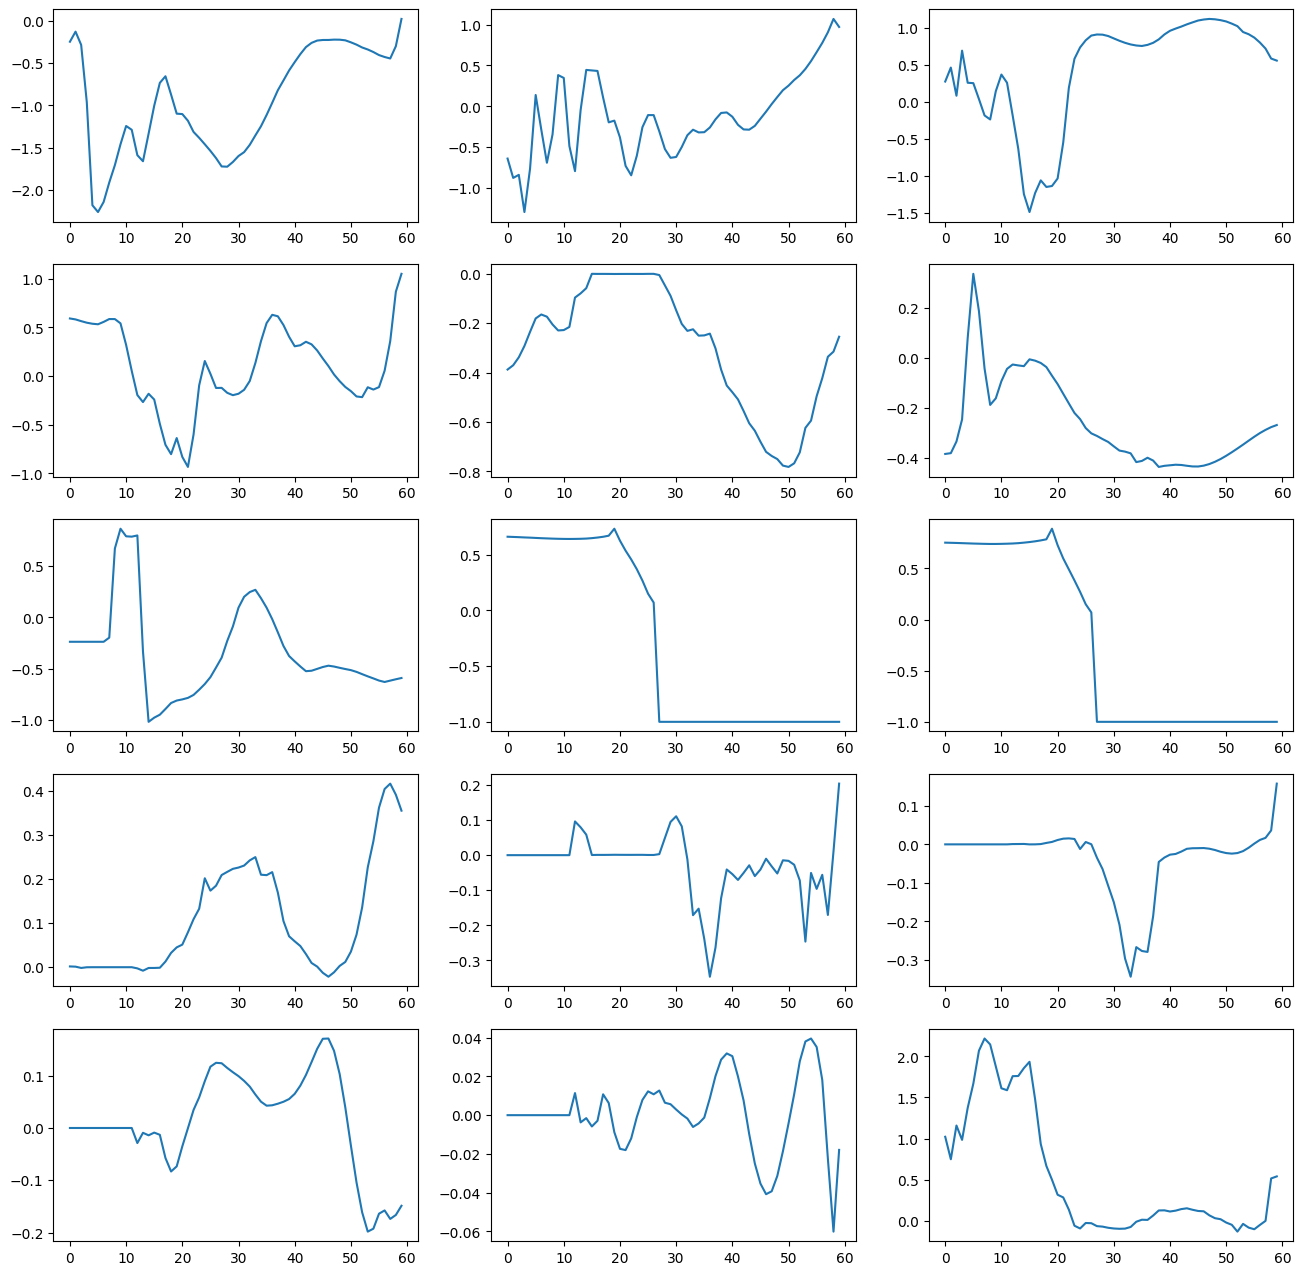

In [43]:
X_point, y_point = X[8], y[8] # nth data point from batch

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16, 16))

axes[0, 0].plot(X_point[STATE_U_IDX])
axes[0, 1].plot(X_point[STATE_V_IDX])
axes[0, 2].plot(X_point[STATE_T_IDX])

axes[1, 0].plot(X_point[STATE_Q0001_IDX])
axes[1, 1].plot(X_point[STATE_Q0002_IDX])
axes[1, 2].plot(X_point[STATE_Q0003_IDX])

axes[2, 0].plot(X_point[PBUF_OZONE_IDX])
axes[2, 1].plot(X_point[PBUF_CH4_IDX])
axes[2, 2].plot(X_point[PBUF_N2O_IDX])

axes[3, 0].plot(y_point[PTEND_Q0001_IDX])
axes[3, 1].plot(y_point[PTEND_Q0002_IDX])
axes[3, 2].plot(y_point[PTEND_Q0003_IDX])

axes[4, 0].plot(y_point[PTEND_U_IDX])
axes[4, 1].plot(y_point[PTEND_V_IDX])
axes[4, 2].plot(y_point[PTEND_T_IDX])

plt.show()

### Training

In [44]:
LOSS_SCALE_TORCH = torch.tensor(LOSS_SCALE, dtype = torch.float64).to(DEVICE) * torch.tensor(TARGET_WEIGHTS, dtype = torch.float64).to(DEVICE)

LOSS_SCALE_TORCH[[-1,-2,-3,-4,-7,-8]] = 0.01 # CAM Values HAS TOO big MSE

In [45]:
def WeightedMSE(y_pred, y):
    return (LOSS_SCALE_TORCH**2 * (y - y_pred) ** 2)

In [46]:
a = torch.rand([2000, 368]).to(DEVICE)
b = torch.rand([2000, 368]).to(DEVICE)
print(WeightedMSE(a, b).mean())
print(WeightedMSE(a, b).mean(0).sum()/a.shape[-1])

tensor(0.1301, device='cuda:0', dtype=torch.float64)
tensor(0.1301, device='cuda:0', dtype=torch.float64)


In [47]:
#model = LeapModel(**nn_config)
model = TfaLeapModel(**nn_config_tfa)
model = model.to(DEVICE)
#model.load_state_dict(torch.load("best_mse_model.pth", map_location=DEVICE))


criterion = nn.MSELoss()
criterion = WeightedMSE
#criterion = torch.nn.HuberLoss(reduction='mean', delta=5.0)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.PolynomialLR(optimizer, power=1.0, total_iters=NUM_EPOCHS)

In [48]:
# scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
#             optimizer,
#             T_0=NUM_EPOCHS,
#             T_mult=1,
#             eta_min=1e-7,
#             last_epoch=-1
#         )

In [49]:
# lrs = []
# for i in range(NUM_EPOCHS):
#     scheduler.step(i)
#     lrs.append(scheduler.get_lr())

In [50]:
#plt.plot(list(range(NUM_EPOCHS)), lrs)

In [51]:
best_score = -np.inf
best_mse = np.inf

scores = []
mses = []
r2s = []
train_mse = []

for epoch in range(0, NUM_EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer, criterion)
    val_score, val_mse, val_r2_full = valid_fn(model, valid_loader)

    train_mse.append(train_loss)
    scores.append(val_score)
    mses.append(val_mse)   
    r2s.append(val_r2_full)   
    
    if val_r2_full > best_score:
        best_score = val_r2_full
        torch.save(model.state_dict(), "best_score_model.pth")

    if val_mse < best_mse:
        best_mse = val_mse
        torch.save(model.state_dict(), "best_mse_model.pth")
        
    torch.save(model.state_dict(), "last_model.pth")
    
    scheduler.step()

Epoch 19: 100%|██████| 1270/1270 [01:34<00:00, 13.47it/s, val_sc=0.929, val_mse=0.365, val_r2=0.669]


In [52]:
history = pd.DataFrame({'train_loss': train_mse, 'mse': mses, 'r2': r2s})

<Axes: >

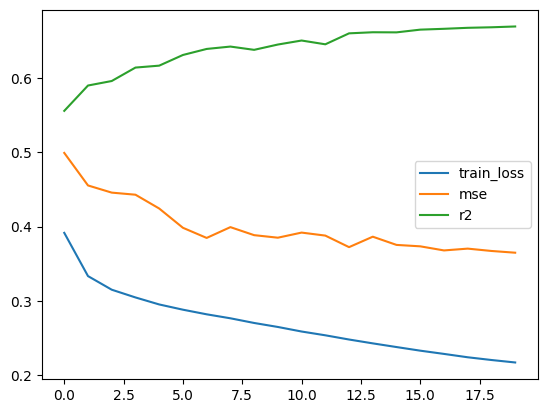

In [53]:
history.plot()

In [54]:
#val_score, val_mse, val_r2_full = valid_fn(model, valid_loader)

In [55]:
#torch.cuda.empty_cache()

# Pred val set

In [56]:
model = TfaLeapModel(**nn_config_tfa)
model = model.to(DEVICE)
model.load_state_dict(torch.load("best_score_model.pth", map_location=DEVICE))

<All keys matched successfully>

In [57]:
def predict_valid(model: nn.Module, loader: DataLoader) -> float:
    """
    Validate the deep learning model for 1 epoch.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to be validated.
    loader : torch.utils.data.DataLoader
        DataLoader for the validation data.

    Returns
    -------
    float
        The average R2 score over the validation epoch.
    """
    
    progress_bar = tqdm(enumerate(loader, start=1), total=len(loader), ncols=100)
    #progress_bar.set_description(f'Epoch {epoch}')
    model.eval()
    val_score = 0
    preds = []
    
    with torch.no_grad():
        for step, batch in progress_bar:
            x, y = batch
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            y_pred = model(x)
            
            y = y.cpu()
            y = (y * Y_STD) + Y_MEAN
            #y = (y * Y_STD)
            y /= torch.tensor(SCALE_WEIGHTS)

            
            y_pred = y_pred.cpu()
            #y_pred[:, Y_STD == 0] = Y_MEAN[:, Y_STD == 0]
            #y_pred[:, Y_STD < (1.1 * ERR)] = Y_MEAN[Y_STD < (1.1 * ERR)]
            
            y_pred = (y_pred * Y_STD) + Y_MEAN
            #y_pred = (y_pred * Y_STD) 
            y_pred /= torch.tensor(SCALE_WEIGHTS)

            
            val_score += r2_score(y_pred, y)
            
            progress_bar.set_postfix({
                'valid_score': val_score / step,
            })
        
            preds.append(y_pred.numpy())
    return np.vstack(preds)

In [58]:
#y_valid = np.concatenate([((yb * Y_STD))/torch.tensor(SCALE_WEIGHTS) for _, yb in valid_loader])
y_valid = np.concatenate([((yb * Y_STD) + Y_MEAN)/torch.tensor(SCALE_WEIGHTS) for _, yb in valid_loader])
#y_valid = np.concatenate([((yb * Y_STD) + Y_MEAN) for _, yb in valid_loader])
#x_valid = np.concatenate([xb for xb, _ in valid_loader])
p_valid = predict_valid(model, valid_loader)

100%|████████████████████████████████████████| 1270/1270 [01:25<00:00, 14.85it/s, valid_score=0.929]


In [59]:
(~np.isfinite(y_valid)).sum()

0

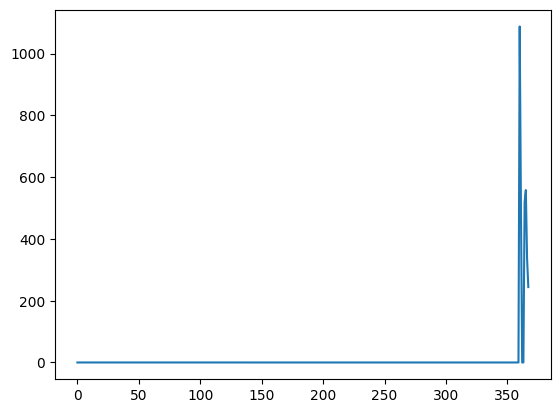

In [60]:
plt.plot(y_valid.max(0)[:368])

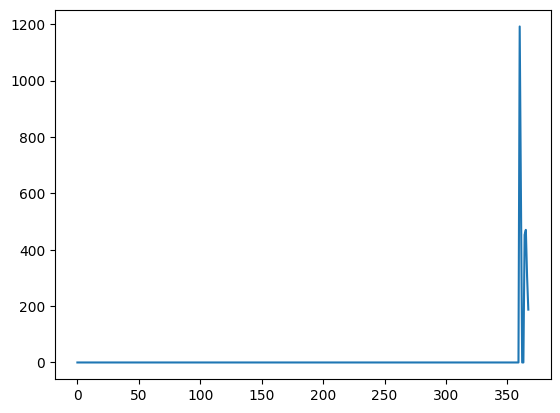

In [61]:
plt.plot(p_valid.max(0)[:368])

In [62]:
p_valid.max(0)[359:]

array([4.98335537e-04, 1.19187213e+03, 6.07544238e+02, 2.04060109e-07,
       1.53643223e-06, 4.52913028e+02, 4.70412231e+02, 3.05606693e+02,
       1.87518708e+02])

In [63]:
Y_MEAN[359:]

array([0.00659128, 0.15831026, 0.35127624, 0.27341459, 0.02919452,
       0.06180362, 0.06732431, 0.33450291, 0.1767569 ])

In [64]:
(nn.MSELoss(reduction='none')(torch.tensor(p_valid), torch.tensor(y_valid)) * torch.tensor(TARGET_WEIGHTS)).sum(1).mean()

tensor(17871.1171, dtype=torch.float64)

In [65]:
r2_score_clipped(torch.tensor(p_valid), torch.tensor(y_valid))

0.6694394713004843

In [66]:
errors = (((p_valid - y_valid)**2)**0.5/368).sum(1)
top_mistakes = (-errors).argsort()

errors[top_mistakes]

array([6.10479875, 4.90266505, 4.78335921, ..., 0.01079872, 0.00858856,
       0.00826683])

In [67]:
mask_errors = errors[top_mistakes] > 1.0
mask_errors.sum()

41576

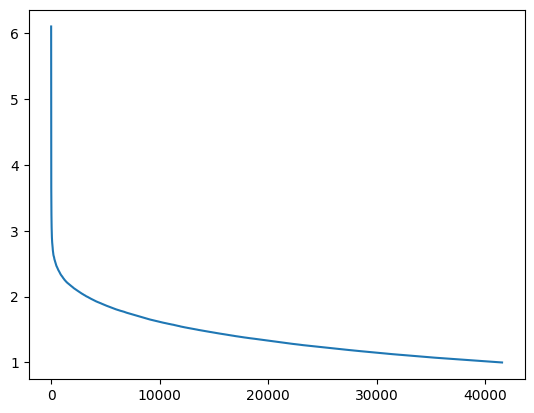

In [68]:
plt.plot(errors[top_mistakes][mask_errors])

0.6694394713004844

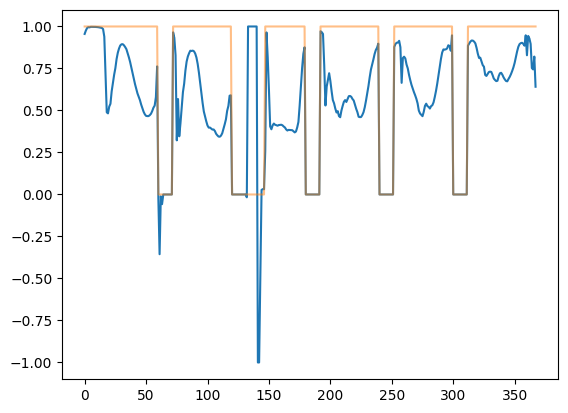

In [69]:


scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(368)]) 
plt.plot(scores_valid.clip(-1, 1))
plt.plot(TARGET_WEIGHTS, alpha = 0.5)
(scores_valid.clip(-1, 1) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum()

0.9580055391896953

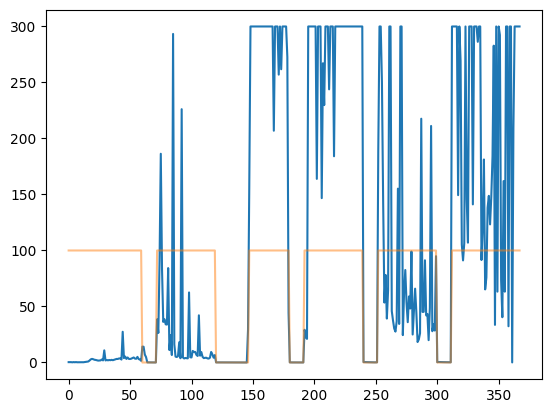

In [70]:
scores_valid = np.array([metrics.mean_absolute_percentage_error(y_valid[:, i], p_valid[:, i]) for i in range(368)]) 
plt.plot(scores_valid.clip(0, 300))
plt.plot(np.array(TARGET_WEIGHTS)*100, alpha = 0.5)
(scores_valid.clip(-1, 1) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum()

In [71]:
y_valid

array([[ 4.34032296e-05,  3.55595851e-05,  6.22985013e-05, ...,
         9.99667621e-01,  1.21815291e+02,  6.25717630e+01],
       [ 3.26754912e-05,  2.98257901e-05,  5.37028143e-05, ...,
         4.84124352e+00,  8.33301558e+01,  5.26811244e+01],
       [ 1.53174146e-05,  2.40041209e-05,  5.66025641e-05, ...,
         6.36448532e+01,  3.40956965e+01,  1.24096848e+01],
       ...,
       [-7.04031783e-06, -4.28462170e-05, -3.41958527e-05, ...,
         1.46481600e-02, -7.75773650e-03,  4.19102096e-03],
       [-8.81801376e-07, -5.00519057e-05, -3.78205400e-05, ...,
         1.46481600e-02, -7.75773650e-03,  4.19102096e-03],
       [ 3.60858525e-05,  5.67812172e-05,  6.14182201e-05, ...,
         3.39189683e+02,  1.00142965e+02,  4.97274354e+01]])

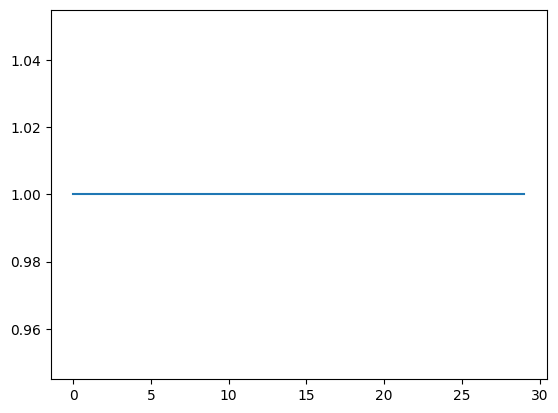

In [72]:
plt.plot(scores_valid.clip(-1, 1)[80:110])

In [73]:
Y_STD[70:110]

array([1.00000000e-16, 1.00000000e-16, 1.15259357e-01, 9.26646159e-02,
       6.83181510e-01, 2.82527620e-01, 2.85637499e-01, 2.16007027e-01,
       4.05532505e-01, 8.83984575e-02, 1.85894519e-01, 4.10275694e-02,
       8.89428372e-02, 1.74130821e-01, 3.06233711e-01, 4.88101169e-01,
       7.01888995e-02, 9.23739157e-02, 1.14478269e-01, 1.37504864e-01,
       1.59475037e-01, 1.77086630e-01, 1.91172754e-01, 2.03608761e-01,
       2.16769175e-01, 2.33311113e-01, 2.53095873e-01, 2.76469064e-01,
       3.03409231e-01, 3.35553072e-01, 3.71215568e-01, 4.10011741e-01,
       4.49273877e-01, 4.86716026e-01, 5.20505820e-01, 5.50603625e-01,
       5.71668172e-01, 5.82665813e-01, 5.88294881e-01, 5.88565213e-01])

In [74]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0][Y_STD[np.array(TARGET_WEIGHTS)>0] == 0]

array([], dtype=float64)

In [75]:
scores_valid[Y_MEAN==0]

array([0.10031565, 0.08112268, 0.05042825, 0.04515277, 0.03318781,
       0.02185893, 0.022094  , 0.02085835, 0.08991884, 0.1047949 ,
       0.07679716, 0.06855859, 0.06963835, 0.0618317 , 0.07462705,
       0.08775384, 0.07742137, 0.07222526, 0.07204022, 0.0683108 ,
       0.11276798, 0.04951722, 0.04552808, 0.05628221, 0.05107045,
       0.04003852, 0.03551763, 0.03749036, 0.03179126, 0.0195111 ,
       0.01791026, 0.01898569, 0.37358629, 0.33766666, 0.30305908,
       0.23083591, 0.19078168, 0.16446753, 0.1408844 , 0.14209099,
       0.12814623, 0.11315517, 0.13408702, 0.15468995, 0.27202834,
       0.43538902, 0.37709524, 0.31460015, 0.30118505, 0.2910344 ,
       0.25988631, 0.21900932, 0.19952914, 0.176484  , 0.15570749,
       0.16625793])

In [76]:
Y_STD[np.array(TARGET_WEIGHTS)>0]

array([0.33904951, 0.44991617, 0.53023997, 0.68980353, 0.91454082,
       1.10335843, 1.03457842, 0.78783475, 0.50254858, 0.38697311,
       2.94961358, 2.26554557, 1.67123934, 1.25858581, 0.93235221,
       0.7419309 , 0.69083685, 0.07965096, 0.1094122 , 0.13763185,
       0.15043989, 0.16075318, 0.18151723, 0.21005089, 0.24184829,
       0.27910623, 0.323123  , 0.37492876, 0.43054877, 0.48962206,
       0.54427667, 0.58454766, 0.61222739, 0.63077924, 0.64200634,
       0.64544652, 0.64074007, 0.63322789, 0.62622654, 0.62011605,
       0.61514178, 0.61097262, 0.61000543, 0.61266751, 0.61629205,
       0.61767403, 0.61208417, 0.60092445, 0.58837284, 0.57431648,
       0.55935203, 0.54387452, 0.52725497, 0.50966103, 0.49168715,
       0.47748374, 0.47209206, 0.48213407, 0.57320541, 0.95958514,
       0.11525936, 0.09266462, 0.68318151, 0.28252762, 0.2856375 ,
       0.21600703, 0.4055325 , 0.08839846, 0.18589452, 0.04102757,
       0.08894284, 0.17413082, 0.30623371, 0.48810117, 0.07018

In [77]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0]

array([ 1.02929261e-01, -6.97155326e-02, -3.15299507e-02, -3.19619268e-02,
       -3.63129338e-02, -2.22857484e-02, -3.13506470e-03,  3.97841919e-03,
        1.83784833e-03, -1.60611399e-04,  1.38263980e-02,  1.86093024e-02,
        2.95191264e-02,  3.75109372e-02,  5.67370059e-02,  9.31576893e-02,
        1.72058030e-01,  1.65372095e-02,  7.61109410e-03, -3.89531922e-03,
       -3.52564088e-03, -2.38466249e-02, -4.12396960e-02, -5.64972054e-02,
       -6.61519066e-02, -6.61819628e-02, -5.81682309e-02, -4.68412721e-02,
       -3.57749574e-02, -2.57151994e-02, -1.68952969e-02, -9.05130939e-03,
       -2.76688278e-03,  1.91246591e-03,  4.85856089e-03,  6.51845951e-03,
        6.98788417e-03,  7.02315626e-03,  6.87885541e-03,  6.06122679e-03,
        4.62000010e-03,  2.56066947e-03, -3.63076626e-04, -3.85495130e-03,
       -6.96830829e-03, -6.93094346e-03, -1.90584647e-03,  6.68160697e-03,
        1.57043694e-02,  2.37879026e-02,  3.05528183e-02,  3.68716334e-02,
        4.26353070e-02,  

In [78]:
Y_MEAN

array([ 1.02929261e-01, -6.97155326e-02, -3.15299507e-02, -3.19619268e-02,
       -3.63129338e-02, -2.22857484e-02, -3.13506470e-03,  3.97841919e-03,
        1.83784833e-03, -1.60611399e-04,  1.38263980e-02,  1.86093024e-02,
        2.95191264e-02,  3.75109372e-02,  5.67370059e-02,  9.31576893e-02,
        1.72058030e-01,  1.65372095e-02,  7.61109410e-03, -3.89531922e-03,
       -3.52564088e-03, -2.38466249e-02, -4.12396960e-02, -5.64972054e-02,
       -6.61519066e-02, -6.61819628e-02, -5.81682309e-02, -4.68412721e-02,
       -3.57749574e-02, -2.57151994e-02, -1.68952969e-02, -9.05130939e-03,
       -2.76688278e-03,  1.91246591e-03,  4.85856089e-03,  6.51845951e-03,
        6.98788417e-03,  7.02315626e-03,  6.87885541e-03,  6.06122679e-03,
        4.62000010e-03,  2.56066947e-03, -3.63076626e-04, -3.85495130e-03,
       -6.96830829e-03, -6.93094346e-03, -1.90584647e-03,  6.68160697e-03,
        1.57043694e-02,  2.37879026e-02,  3.05528183e-02,  3.68716334e-02,
        4.26353070e-02,  

In [79]:
import math

S_WEIGHTS = []

for val in Y_MEAN:
    if val != 0:
        logval = math.log10(abs(val))
        S_WEIGHTS.append(-round(logval - (0.5 if logval<0 else 0)))
    else:
        S_WEIGHTS.append(0)


S_WEIGHTS = [float(f'1e{f}') for f in S_WEIGHTS]

In [80]:
print(S_WEIGHTS)

[10.0, 100.0, 100.0, 100.0, 100.0, 100.0, 1000.0, 1000.0, 1000.0, 10000.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 10.0, 100.0, 1000.0, 1000.0, 1000.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 10000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 10.0, 10.0, 10000.0, 10000.0, 10000.0, 1e+19, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10000.0, 10000.0, 1000.0, 10000.0, 10000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 1000.0, 1000.0, 1000.0, 100.0, 100.0, 1000.0, 1000.0, 1000.0, 100.0, 100.0, 100.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000.0, 1000.0, 1000.0, 100.0, 0.0001, 0.0001, 0.001, 0.01, 0.01, 0.01, 0

In [81]:
round(logval - (0.5 if logval<0 else 0))

-1

In [82]:
S_WEIGHTS = []

for yy in Y_MEAN:
    T = 1
    if abs(yy) > 1:
        T = 1   
    elif abs(yy) > 1e-6:
        T = 1e6
    elif abs(yy) > 1e-10:
        T = 1e10    
    elif abs(yy) > 1e-16:
        T = 1e16            
    elif abs(yy) > 1e-20:
        T = 1e20        
    elif abs(yy) > 1e-24:
        T = 1e24        
    elif abs(yy) > 1e-30:
        T = 1e30
    elif abs(yy) > 1e-36:
        T = 1e36
    elif abs(yy) <= 1e-36:
        T = 1e36
    S_WEIGHTS.append(T)
                    

In [83]:
print(S_WEIGHTS)

[1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1e+20, 1e+36, 1e+36, 1e+36, 1e+36, 1e+36, 1e+36, 1e+36, 1e+36, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1

In [84]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0][Y_STD[np.array(TARGET_WEIGHTS)>0] == ERR]

array([], dtype=float64)

In [85]:
Y_STD[np.array(TARGET_WEIGHTS)>0]

array([0.33904951, 0.44991617, 0.53023997, 0.68980353, 0.91454082,
       1.10335843, 1.03457842, 0.78783475, 0.50254858, 0.38697311,
       2.94961358, 2.26554557, 1.67123934, 1.25858581, 0.93235221,
       0.7419309 , 0.69083685, 0.07965096, 0.1094122 , 0.13763185,
       0.15043989, 0.16075318, 0.18151723, 0.21005089, 0.24184829,
       0.27910623, 0.323123  , 0.37492876, 0.43054877, 0.48962206,
       0.54427667, 0.58454766, 0.61222739, 0.63077924, 0.64200634,
       0.64544652, 0.64074007, 0.63322789, 0.62622654, 0.62011605,
       0.61514178, 0.61097262, 0.61000543, 0.61266751, 0.61629205,
       0.61767403, 0.61208417, 0.60092445, 0.58837284, 0.57431648,
       0.55935203, 0.54387452, 0.52725497, 0.50966103, 0.49168715,
       0.47748374, 0.47209206, 0.48213407, 0.57320541, 0.95958514,
       0.11525936, 0.09266462, 0.68318151, 0.28252762, 0.2856375 ,
       0.21600703, 0.4055325 , 0.08839846, 0.18589452, 0.04102757,
       0.08894284, 0.17413082, 0.30623371, 0.48810117, 0.07018

In [86]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0]

array([ 1.02929261e-01, -6.97155326e-02, -3.15299507e-02, -3.19619268e-02,
       -3.63129338e-02, -2.22857484e-02, -3.13506470e-03,  3.97841919e-03,
        1.83784833e-03, -1.60611399e-04,  1.38263980e-02,  1.86093024e-02,
        2.95191264e-02,  3.75109372e-02,  5.67370059e-02,  9.31576893e-02,
        1.72058030e-01,  1.65372095e-02,  7.61109410e-03, -3.89531922e-03,
       -3.52564088e-03, -2.38466249e-02, -4.12396960e-02, -5.64972054e-02,
       -6.61519066e-02, -6.61819628e-02, -5.81682309e-02, -4.68412721e-02,
       -3.57749574e-02, -2.57151994e-02, -1.68952969e-02, -9.05130939e-03,
       -2.76688278e-03,  1.91246591e-03,  4.85856089e-03,  6.51845951e-03,
        6.98788417e-03,  7.02315626e-03,  6.87885541e-03,  6.06122679e-03,
        4.62000010e-03,  2.56066947e-03, -3.63076626e-04, -3.85495130e-03,
       -6.96830829e-03, -6.93094346e-03, -1.90584647e-03,  6.68160697e-03,
        1.57043694e-02,  2.37879026e-02,  3.05528183e-02,  3.68716334e-02,
        4.26353070e-02,  

In [87]:
[Y_STD[np.array(TARGET_WEIGHTS)>0] == ERR]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [88]:
np.log(6.8322e-37)

-83.27400171071722

In [89]:
Y_MEAN

array([ 1.02929261e-01, -6.97155326e-02, -3.15299507e-02, -3.19619268e-02,
       -3.63129338e-02, -2.22857484e-02, -3.13506470e-03,  3.97841919e-03,
        1.83784833e-03, -1.60611399e-04,  1.38263980e-02,  1.86093024e-02,
        2.95191264e-02,  3.75109372e-02,  5.67370059e-02,  9.31576893e-02,
        1.72058030e-01,  1.65372095e-02,  7.61109410e-03, -3.89531922e-03,
       -3.52564088e-03, -2.38466249e-02, -4.12396960e-02, -5.64972054e-02,
       -6.61519066e-02, -6.61819628e-02, -5.81682309e-02, -4.68412721e-02,
       -3.57749574e-02, -2.57151994e-02, -1.68952969e-02, -9.05130939e-03,
       -2.76688278e-03,  1.91246591e-03,  4.85856089e-03,  6.51845951e-03,
        6.98788417e-03,  7.02315626e-03,  6.87885541e-03,  6.06122679e-03,
        4.62000010e-03,  2.56066947e-03, -3.63076626e-04, -3.85495130e-03,
       -6.96830829e-03, -6.93094346e-03, -1.90584647e-03,  6.68160697e-03,
        1.57043694e-02,  2.37879026e-02,  3.05528183e-02,  3.68716334e-02,
        4.26353070e-02,  

In [90]:
np.finfo(np.float32)

finfo(resolution=1e-06, min=-3.4028235e+38, max=3.4028235e+38, dtype=float32)

In [91]:
Y_STD[np.array(TARGET_WEIGHTS)>0]

array([0.33904951, 0.44991617, 0.53023997, 0.68980353, 0.91454082,
       1.10335843, 1.03457842, 0.78783475, 0.50254858, 0.38697311,
       2.94961358, 2.26554557, 1.67123934, 1.25858581, 0.93235221,
       0.7419309 , 0.69083685, 0.07965096, 0.1094122 , 0.13763185,
       0.15043989, 0.16075318, 0.18151723, 0.21005089, 0.24184829,
       0.27910623, 0.323123  , 0.37492876, 0.43054877, 0.48962206,
       0.54427667, 0.58454766, 0.61222739, 0.63077924, 0.64200634,
       0.64544652, 0.64074007, 0.63322789, 0.62622654, 0.62011605,
       0.61514178, 0.61097262, 0.61000543, 0.61266751, 0.61629205,
       0.61767403, 0.61208417, 0.60092445, 0.58837284, 0.57431648,
       0.55935203, 0.54387452, 0.52725497, 0.50966103, 0.49168715,
       0.47748374, 0.47209206, 0.48213407, 0.57320541, 0.95958514,
       0.11525936, 0.09266462, 0.68318151, 0.28252762, 0.2856375 ,
       0.21600703, 0.4055325 , 0.08839846, 0.18589452, 0.04102757,
       0.08894284, 0.17413082, 0.30623371, 0.48810117, 0.07018

In [92]:
mask = scores_valid <= 1e-3

p_test = np.array(p_valid)
p_test[:, mask] = Y_MEAN[mask]

0.5155641274144138

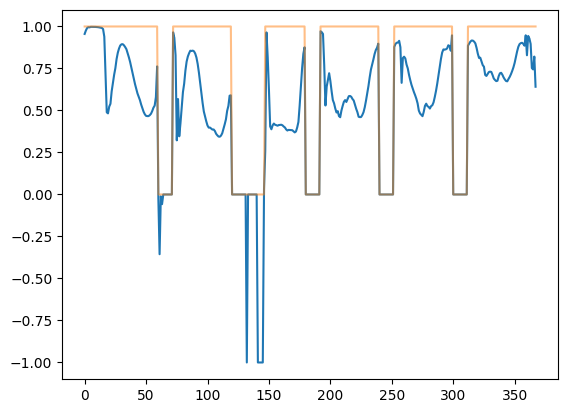

In [93]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_test[:, i]) for i in range(368)])
plt.plot(scores_valid.clip(-1, 1))
plt.plot(TARGET_WEIGHTS, alpha = 0.5)
scores_valid.clip(-1, 1).mean()

### Evaluation

In [94]:
model = LeapModel(**nn_config)
model = model.to(DEVICE)
model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
#model.load_state_dict(torch.load("/kaggle/input/leap-models/first_leap_model.pth", map_location=DEVICE))

df_test = pl.read_csv(TEST_PATH)
df_test = df_test.to_pandas()
df_test = df_test.set_index("sample_id")

df_subm = pl.read_csv(SUBMISSION_PATH)
df_subm = df_subm.to_pandas()
df_subm = df_subm.set_index("sample_id")

static_pred = -df_test[REPLACE_TO].to_numpy() * df_subm[REPLACE_FROM].to_numpy() / 1200

RuntimeError: Error(s) in loading state_dict for LeapModel:
	Unexpected key(s) in state_dict: "out_att_blocks.0.sa.in_proj_weight", "out_att_blocks.0.sa.in_proj_bias", "out_att_blocks.0.sa.out_proj.weight", "out_att_blocks.0.sa.out_proj.bias", "out_att_blocks.0.ffwd.net.0.weight", "out_att_blocks.0.ffwd.net.0.bias", "out_att_blocks.0.ffwd.net.2.weight", "out_att_blocks.0.ffwd.net.2.bias", "out_att_blocks.0.ln1.weight", "out_att_blocks.0.ln1.bias", "out_att_blocks.0.ln2.weight", "out_att_blocks.0.ln2.bias", "out_att_blocks.1.sa.in_proj_weight", "out_att_blocks.1.sa.in_proj_bias", "out_att_blocks.1.sa.out_proj.weight", "out_att_blocks.1.sa.out_proj.bias", "out_att_blocks.1.ffwd.net.0.weight", "out_att_blocks.1.ffwd.net.0.bias", "out_att_blocks.1.ffwd.net.2.weight", "out_att_blocks.1.ffwd.net.2.bias", "out_att_blocks.1.ln1.weight", "out_att_blocks.1.ln1.bias", "out_att_blocks.1.ln2.weight", "out_att_blocks.1.ln2.bias", "out_att_blocks.2.sa.in_proj_weight", "out_att_blocks.2.sa.in_proj_bias", "out_att_blocks.2.sa.out_proj.weight", "out_att_blocks.2.sa.out_proj.bias", "out_att_blocks.2.ffwd.net.0.weight", "out_att_blocks.2.ffwd.net.0.bias", "out_att_blocks.2.ffwd.net.2.weight", "out_att_blocks.2.ffwd.net.2.bias", "out_att_blocks.2.ln1.weight", "out_att_blocks.2.ln1.bias", "out_att_blocks.2.ln2.weight", "out_att_blocks.2.ln2.bias", "head.expand.weight", "head.expand.bias", "head.out.weight", "head.out.bias". 
	size mismatch for fe.Scales60.0.weight: copying a param with shape torch.Size([64, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for fe.Scales60.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.Scales60.1.weight: copying a param with shape torch.Size([64, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for fe.Scales60.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.Scales60.2.weight: copying a param with shape torch.Size([64, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for fe.Scales60.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.Scales60.3.weight: copying a param with shape torch.Size([64, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for fe.Scales60.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.Scales60.4.weight: copying a param with shape torch.Size([64, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for fe.Scales60.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.Scales60.5.weight: copying a param with shape torch.Size([64, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for fe.Scales60.5.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.Scales60.6.weight: copying a param with shape torch.Size([64, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for fe.Scales60.6.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.Scales60.7.weight: copying a param with shape torch.Size([64, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for fe.Scales60.7.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.Scales60.8.weight: copying a param with shape torch.Size([64, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for fe.Scales60.8.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ScalesFlat.0.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.1.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.2.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.3.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.4.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.5.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.5.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.6.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.7.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.7.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.8.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.9.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.9.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.10.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.11.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.11.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.12.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.13.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.13.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.14.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ScalesFlat.15.weight: copying a param with shape torch.Size([32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1]).
	size mismatch for fe.ScalesFlat.15.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExt60.0.conv.dw_conv.weight: copying a param with shape torch.Size([128, 1, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7]).
	size mismatch for fe.ConvExt60.0.dnn_expand.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([64, 32]).
	size mismatch for fe.ConvExt60.0.dnn_expand.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.0.dnn_project.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for fe.ConvExt60.0.dnn_project.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExt60.0.bn.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.0.bn.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.0.bn.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.0.bn.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.1.conv.dw_conv.weight: copying a param with shape torch.Size([128, 1, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7]).
	size mismatch for fe.ConvExt60.1.dnn_expand.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([64, 32]).
	size mismatch for fe.ConvExt60.1.dnn_expand.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.1.dnn_project.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for fe.ConvExt60.1.dnn_project.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExt60.1.bn.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.1.bn.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.1.bn.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.1.bn.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.2.conv.dw_conv.weight: copying a param with shape torch.Size([128, 1, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7]).
	size mismatch for fe.ConvExt60.2.dnn_expand.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([64, 32]).
	size mismatch for fe.ConvExt60.2.dnn_expand.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.2.dnn_project.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for fe.ConvExt60.2.dnn_project.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExt60.2.bn.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.2.bn.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.2.bn.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.2.bn.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.3.conv.dw_conv.weight: copying a param with shape torch.Size([128, 1, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7]).
	size mismatch for fe.ConvExt60.3.dnn_expand.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([64, 32]).
	size mismatch for fe.ConvExt60.3.dnn_expand.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.3.dnn_project.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for fe.ConvExt60.3.dnn_project.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExt60.3.bn.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.3.bn.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.3.bn.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.3.bn.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.4.conv.dw_conv.weight: copying a param with shape torch.Size([128, 1, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7]).
	size mismatch for fe.ConvExt60.4.dnn_expand.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([64, 32]).
	size mismatch for fe.ConvExt60.4.dnn_expand.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.4.dnn_project.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for fe.ConvExt60.4.dnn_project.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExt60.4.bn.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.4.bn.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.4.bn.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.4.bn.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.5.conv.dw_conv.weight: copying a param with shape torch.Size([128, 1, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7]).
	size mismatch for fe.ConvExt60.5.dnn_expand.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([64, 32]).
	size mismatch for fe.ConvExt60.5.dnn_expand.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.5.dnn_project.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for fe.ConvExt60.5.dnn_project.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExt60.5.bn.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.5.bn.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.5.bn.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.5.bn.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.6.conv.dw_conv.weight: copying a param with shape torch.Size([128, 1, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7]).
	size mismatch for fe.ConvExt60.6.dnn_expand.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([64, 32]).
	size mismatch for fe.ConvExt60.6.dnn_expand.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.6.dnn_project.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for fe.ConvExt60.6.dnn_project.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExt60.6.bn.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.6.bn.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.6.bn.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.6.bn.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.7.conv.dw_conv.weight: copying a param with shape torch.Size([128, 1, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7]).
	size mismatch for fe.ConvExt60.7.dnn_expand.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([64, 32]).
	size mismatch for fe.ConvExt60.7.dnn_expand.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.7.dnn_project.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for fe.ConvExt60.7.dnn_project.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExt60.7.bn.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.7.bn.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.7.bn.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.7.bn.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.8.conv.dw_conv.weight: copying a param with shape torch.Size([128, 1, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7]).
	size mismatch for fe.ConvExt60.8.dnn_expand.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([64, 32]).
	size mismatch for fe.ConvExt60.8.dnn_expand.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.8.dnn_project.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for fe.ConvExt60.8.dnn_project.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExt60.8.bn.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.8.bn.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.8.bn.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExt60.8.bn.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fe.ConvExtFlat.0.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.0.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.0.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.0.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.0.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.0.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.0.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.0.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.0.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.1.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.1.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.1.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.1.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.1.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.1.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.1.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.1.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.1.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.2.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.2.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.2.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.2.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.2.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.2.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.2.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.2.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.2.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.3.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.3.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.3.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.3.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.3.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.3.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.3.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.3.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.3.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.4.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.4.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.4.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.4.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.4.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.4.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.4.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.4.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.4.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.5.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.5.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.5.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.5.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.5.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.5.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.5.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.5.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.5.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.6.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.6.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.6.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.6.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.6.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.6.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.6.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.6.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.6.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.7.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.7.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.7.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.7.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.7.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.7.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.7.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.7.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.7.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.8.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.8.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.8.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.8.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.8.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.8.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.8.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.8.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.8.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.9.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.9.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.9.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.9.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.9.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.9.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.9.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.9.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.9.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.10.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.10.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.10.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.10.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.10.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.10.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.10.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.10.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.10.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.11.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.11.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.11.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.11.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.11.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.11.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.11.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.11.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.11.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.12.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.12.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.12.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.12.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.12.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.12.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.12.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.12.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.12.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.13.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.13.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.13.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.13.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.13.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.13.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.13.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.13.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.13.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.14.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.14.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.14.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.14.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.14.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.14.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.14.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.14.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.14.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.15.conv.dw_conv.weight: copying a param with shape torch.Size([64, 1, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7]).
	size mismatch for fe.ConvExtFlat.15.dnn_expand.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for fe.ConvExtFlat.15.dnn_expand.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.15.dnn_project.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for fe.ConvExtFlat.15.dnn_project.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fe.ConvExtFlat.15.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.15.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.15.bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fe.ConvExtFlat.15.bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for linearStem.weight: copying a param with shape torch.Size([256, 1088]) from checkpoint, the shape in current model is torch.Size([128, 544]).
	size mismatch for linearStem.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bottleneck.conv.dw_conv.weight: copying a param with shape torch.Size([512, 512, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3]).
	size mismatch for bottleneck.dnn_expand.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([256, 128]).
	size mismatch for bottleneck.dnn_expand.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.dnn_project.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for bottleneck.dnn_project.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bottleneck.bn.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.bn.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.bn.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.bn.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for blocks.0.conv.0.conv.dw_conv.weight: copying a param with shape torch.Size([512, 1, 5]) from checkpoint, the shape in current model is torch.Size([256, 1, 5]).
	size mismatch for blocks.0.conv.0.dnn_expand.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([256, 128]).
	size mismatch for blocks.0.conv.0.dnn_expand.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for blocks.0.conv.0.dnn_project.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for blocks.0.conv.0.dnn_project.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for blocks.0.conv.0.bn.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for blocks.0.conv.0.bn.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for blocks.0.conv.0.bn.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for blocks.0.conv.0.bn.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for blocks.0.conv.1.conv.dw_conv.weight: copying a param with shape torch.Size([512, 512, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3]).
	size mismatch for blocks.0.conv.1.dnn_expand.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([256, 128]).
	size mismatch for blocks.0.conv.1.dnn_expand.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for blocks.0.conv.1.dnn_project.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for blocks.0.conv.1.dnn_project.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for blocks.0.conv.1.bn.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for blocks.0.conv.1.bn.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for blocks.0.conv.1.bn.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for blocks.0.conv.1.bn.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for blocks.0.block.sa.in_proj_weight: copying a param with shape torch.Size([768, 256]) from checkpoint, the shape in current model is torch.Size([384, 128]).
	size mismatch for blocks.0.block.sa.in_proj_bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for blocks.0.block.sa.out_proj.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for blocks.0.block.sa.out_proj.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for blocks.0.block.ffwd.net.0.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([256, 128]).
	size mismatch for blocks.0.block.ffwd.net.0.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for blocks.0.block.ffwd.net.2.weight: copying a param with shape torch.Size([256, 1024]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for blocks.0.block.ffwd.net.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for blocks.0.block.ln1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for blocks.0.block.ln1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for blocks.0.block.ln2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for blocks.0.block.ln2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for head.conv_seq.weight: copying a param with shape torch.Size([6, 256, 1]) from checkpoint, the shape in current model is torch.Size([6, 128, 1]).
	size mismatch for head.conv_flat.weight: copying a param with shape torch.Size([8, 256, 1]) from checkpoint, the shape in current model is torch.Size([8, 128, 1]).

In [ ]:
df_subm.loc[df_test.index, TARGET_NAMES] = pred_fn(model, df_test)

df_subm[REPLACE_FROM] = static_pred

df_subm = df_subm.reset_index()
df_subm = df_subm[["sample_id"] + TARGET_NAMES]

df_subm = pl.from_pandas(df_subm)
df_subm.write_csv("submission.csv")

In [ ]:
import pandas as pd

df = pd.concat([
    pd.read_parquet('train_data_sample_3kk_part_1.parquet'),
    pd.read_parquet('train_data_sample_3kk_part_2.parquet')]
              )

